# Custom Tokenizer

## Introduction

In this notebook we will develop a custom tokenizer, train it and store it.


In order to do this, this notebook consists of the following sections:
- Data preparation: loading all required data in the proper form
- Creating a dictionary with the morphological segmentations of Dutch words
- Creating the tokenizer using this dictionary
- Evaluating the tokenizer and comparing it to other tokenizers

## Data preparation

We have two main sources of data:
- OSCAR: a corpus with a lot of Dutch text data
- CELEX: a database with information about Dutch words

### OSCAR 


There are a couple of ways to work with the OSCAR corpus. The main choice we have to make is whether we want to download the corpus to our personal computer first, or download the dataset (in segments, as the dataset is too large to lead into memory at once) from the Hugging Face library when we want to use it for a certain task. 

Downloading the corpus manually is done in 45 segments. This means we could load one of these segments into memory at once, but it is easier to make a generator that behaves in the same way as the one that is necessary for streaming the dataset directly from Hugging Face, so that our functions can handle both. 

We will also create a small dataset in that can be used for testing some functions.

In [2]:
# from datasets import load_dataset, DatasetDict
# import os


# # function that returns a dictionary with a generator for every existing OSCAR file in this computer
# def create_local_oscar_generators(data_path, i=0, j=0):

#     out = {}
    
#     if j > i:
#         n = j - i

#         for x in range(i, j+1):
#             full_path = os.path.join(data_path, 'OSCAR', f'nl_part_{x}.txt')
#             if os.path.isfile(full_path):
#                 out[f'oscar{i}'] = create_text_generator(load_dataset('text', data_files={"train": full_path}, split='train', streaming=True))
        
#         if len(out) != n + 1:
#             print('Not all parts requested are on this computer')
    
#     else:

#         for i in range(1, 50):
#             full_path = os.path.join(data_path, 'OSCAR', f'nl_part_{i}.txt')
#             if os.path.isfile(full_path):
#                 out[f'oscar{i}'] = create_text_generator(load_dataset('text', data_files={"train": full_path}, split='train', streaming=True))


#     return out


# # function that creates one generator out of multiple generators
# def create_super_generator(generator_dict, list_input=False):

#     if list_input:
#         for generator in generator_dict:
#             yield from generator
#     else:
#         for generator in generator_dict.values():
#             yield from generator


# # one function to create OSCAR generator by combining n parts of the dataset, from part i to part j
# def create_super_local_oscar_generator(data_path, i=0, j=0):
    
#     if j > i:
#         generators = create_local_oscar_generators(data_path, i=i, j=j)
#     else:
#         generators = create_local_oscar_generators(data_path)

#     return create_super_generator(generators)


# # function to create a dataset with text 
# def create_test_set(dataset_generator, start, end):
#     it = iter(dataset_generator)
#     for _ in range(start):
#         next(it)
#     for _ in range(end - start + 1):
#         yield next(it)


# # function to turn a generator that returns a dictionary with 'text' as key into a generator of the values
# def create_text_generator(gen):
#     for i in gen:
#         yield i['text']


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# # set path to datasets
# data_path = '/Users/jan/Documents/Master/Thesis/Code/Datasets'

# # download from huggingface
# dataset_from_hub = load_dataset('oscar', 'unshuffled_deduplicated_nl', split='train', streaming=True, trust_remote_code=True)

# # create from local files
# oscar1 = os.path.join(data_path, 'OSCAR', 'nl_part_1.txt')
# data_files = {"train": oscar1}
# oscar_it_dict = load_dataset('text', data_files=data_files, split='train', streaming=True)

# # create dictionary with a generator for every part
# gen_dict = create_local_oscar_generators(data_path)

# # create from local files
# oscar_gen_1 = gen_dict['oscar1']
# oscar_gen_2 = gen_dict['oscar2']

# # create super generator from all OSCAR files on computer
# oscar_gen_super = create_super_local_oscar_generator(data_path)

# # create small dataset (uneven number of lines)
# oscar_gen_small = create_test_set(oscar_gen_1, 0, 100007)

### CELEX

The CELEX database consists of more than 10 datasets, all focused on different features of language. For our purposes, we use two of these datasets:
- one with morphological segmentations
- one with information that we can use to create groups of related words

In [1]:
# set path to datasets
import os
data_path = '/Users/jan/Documents/Master/Thesis/Code/Datasets'

In [2]:


celex = os.path.join(data_path, 'CELEX-2-NL', 'DUTCH', 'DML', 'DML.CD')
celex2 = os.path.join(data_path, 'CELEX-2-NL', 'DUTCH', 'DFW', 'DFW.CD')

### SimLex

In [3]:
def load_simlex(simlex999, scores=False):
    # create list with a tuple for every word pair in the form of (word_1, word_2, similarity score, POS-tag)
    word_pairs = []

    # create a set with all words
    words_set = set([])

    with open(simlex999) as simlex:
        
        next(simlex) # skip first line
        
        for line in simlex:
    
            split = line.strip().split('\t')
            word_pairs.append(tuple(split))
            words_set.add(split[0])
            words_set.add(split[1])

    # create a list of unique words
    simlex_words = list(words_set)

    if scores:
        return word_pairs
    else:
        return simlex_words
        

In [4]:
simlex_path = os.path.join(data_path, 'SimLex-999', 'SimLex-999-Dutch-final.txt')
simlex_words = load_simlex(simlex_path)
simlex_pairs = load_simlex(simlex_path, scores=True)

### Word list

For purposes that will be made clear later on, we want a list with as many Dutch words as possible. We will use three sources for this:
     - a list found at https://github.com/OpenTaal/opentaal-wordlist
     - the celex database
     - a text corpus

The first two sources are reliable and we can be very sure that all entries are actually words. The third source is different, as this list is compiled by data from webscraping, which means there are a lot of spelling mistakes, non-Dutch words, etc. We will therefore use a treshold of the number of times the word occurs in the corpus. This will not eliminate all errors, for instance, common spelling mistakes might still be in there. This is not a big problem, however. The reason for this will also become clear later on.

The source is very helpful, as the first two sources are not complete. Not all words are present (for instance fairly new words), and not all conjugations of nouns and verbs are present. So we must use the corpus as well. 

In [6]:
# source 1
word_list1 = '/Users/jan/Documents/Master/Thesis/Code/Datasets/Woordenlijsten/wordlist.txt'

# create set
words_opentaal = set([])
with open(word_list1) as wl:
    for line in wl:
        words_opentaal.add(line.strip())

In [8]:
# source 2 

def extract_celex_words(celex):
    
    out = set([])

    with open(celex) as cd:
        for line in cd:

            line = line.strip().split('\\')
            out.add(line[1])
    
    return out

# (we use two parts of celex)
words_celex1 = extract_celex_words(celex)
words_celex2 = extract_celex_words(celex2)

We can see how many words this gives us. We will also change the words to lowercase.

In [9]:
intial_words_set = words_opentaal | words_celex1 | words_celex2
intial_words_lower = {word.lower() for word in intial_words_set}

len(intial_words_lower)

528865

We already have a list with 528865 words. Let's see if we can get some additional words from the text corpus.

For the corpus, we load a dictionary with the occurence frequency I have compiled outside of this notebook.

In [16]:
import json

# store a dictionary in a json file
def load_json(path):
    with open(path, 'r') as f:
        my_dict = json.load(f)
    return my_dict


# source 3
word_freqs = load_json('/Users/jan/Documents/Master/Thesis/Code/Snellius/Outputs/frequencies20.json')

In [17]:
words_corpus = set([])

for word, freq in word_freqs.items():
    if freq > 1000:
        words_corpus.add(word)

The words were abstracted from the corpus with the preprocessing of a tokenizer. This means some additional processing must be performed, namely taking out the elements with numbers and some special characters.

In [18]:
import re

words_corpus_treshold = set([])
for word in words_corpus:
    if not word in intial_words_set:
        words_corpus_treshold.add(word)

def contains_unwanted_characters(s):
    return bool(re.search(r'[^a-zA-Z\s-]', s))

words_corpus_filtered = {word for word in words_corpus_treshold if not contains_unwanted_characters(word)}


In [19]:
words_complete_lower = intial_words_lower | words_corpus_filtered

In [20]:
print(f'We now have a list of {len(words_complete_lower)} words!')

We now have a list of 557726 words!


Let's store the list in a json file:

In [16]:

# load a dictionary from a json file
def store_json(path, object):
    with open(path, 'w') as f:
        json.dump(object, f)

words_list = list(words_complete_lower)

store_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/Woordenlijsten/words_complete_lower.json', words_list)

And let's store it as a text file:

In [17]:
with open('/Users/jan/Documents/Master/Thesis/Code/Datasets/Woordenlijsten/words_complete_lower.txt', 'w') as file:
    for word in words_list:
        file.write(word + "\n")

## Morfessor

This is an existing module that is based on several (statistical) methods to morphologically segment a word. A model is trained with a list of words. For this we will use the list we have compiled above.

In [327]:

import math
import morfessor



### Commented so we don't run this again ###




# def log_func(x):
#     return int(round(math.log(x + 1, 2)))

# infile = '/Users/jan/Documents/Master/Thesis/Code/Datasets/Woordenlijsten/words_complete_lower.txt'
# io = morfessor.MorfessorIO()
# train_data = list(io.read_corpus_file(infile))
# model_nl = morfessor.BaselineModel()
# model_nl.load_data(train_data, count_modifier=log_func)
# model_nl.train_batch()
# io.write_binary_model_file("model_nl_complete.bin", model_nl)

...........................................................
...........................................................
...........................................................
...........................................................
...........................................................
...........................................................


In [330]:
model_file = "model_nl.bin"
io = morfessor.MorfessorIO()
model_nl = io.read_binary_model_file(model_file)

word = 'huisarrest'
# for segmenting new words we use the viterbi_segment(compound) method
print(model_nl.viterbi_segment(word)[0])

['huis', 'arrest']


Let's say we want to use this model in our tokenization algorithm. Let's first see how long it takes to tokenize all 528.000 words with this model. 

In [331]:
morfessor_dictionary = {}
for word in words_complete_lower:
    morfessor_dictionary[word] = model_nl.viterbi_segment(word)[0]

Unfortunately, this is too slow to use in a tokenizer directly. However, it is possible to first create a dictionary with the segmentation and use that in the tokenizer.

Next, let's see the number of morphemes the words are split into. 






In [334]:
morfessor_morphemes = set([])
for segs in morfessor_dictionary.values():
    for seg in segs:
        morfessor_morphemes.add(seg)
    
len(morfessor_morphemes)

37686

This also poses a problem, as this is too many. This is because the morphemes that occur both as the first and as not the first segment of a word must each require their own token, and thus must be counted double. Let's define a function to count this:

In [339]:
def count_morphemes_extra(df, print_info=True):

    total = set([])
    begin = set([])
    mid = set([])

    for word, segs in df.items():
        if len(segs) > 0:
            begin.add(segs[0])
        if len(segs) > 1:
           for item in segs[1:]:
               mid.add(item)
        for seg in segs:
            total.add(seg)

    not_at_begin = mid - begin

    size = len(total) + len(begin) - len(not_at_begin)

    if print_info:
    
        print(f'There are {len(total)} morphemes, out of these {len(begin)} appear at the beginning of a word')
        print(f'{len(not_at_begin)} morphemes do not appear at the beginning. This means that the vocabulary has a size of {size} tokens (only lowercase).')
    
    else:
        return size

In [340]:
count_morphemes_extra(morfessor_dictionary)

There are 37686 morphemes, out of these 35511 appear at the beginning of a word
2175 morphemes do not appear at the beginning. This means that the vocabulary has a size of 71022 tokens (only lowercase).


71022 is too many. We might be able to solve this by removing the least used ones. We will return to this problem later on.

## Creating a segmentation dictionary from CELEX

### Functions to create dictionaries

The goal of this section is to construct a dataset with the morphological segmentation of as many Dutch words as possible. Luckily, there already is such a dataset available, as part of the CELEX database. 

This dataset, however, is only the starting point. The two main things we do to augment it is deleting unusable entries and, more importantly, adding more entries. This means that some algorithms must be developed that can provide the morphological segmentation of words that are not in the CELEX database, based on words that are in the dataset. 

For every reduction or expansion of the dataset, a function is defined. 

The functions can be devided into four categories:
- basic or helper functions to let us handle the data more easily
- functions to remove entries
- functions to create new entries

We will apply these functions to the CELEX database one-by-one, in order to see the effect of the changes made. We will make some plots to visualize these effects. 


#### Helper functions

In [21]:
import re
import copy
import json
import pandas as pd




# store a dictionary in a json file
def load_json(path):
    with open(path, 'r') as f:
        my_dict = json.load(f)
    return my_dict

# load a dictionary from a json file
def store_json(path, object):
    with open(path, 'w') as f:
        json.dump(object, f)


def merge_dicts(original, extra, replace=True):
    if replace:
        return original | extra
    else: 
        return extra | original


def merge_based_on_length(orig, extra, replace=True):
    
    original = {}

    for word, segs in orig.items():
        original[word] = segs
    
    if replace:
        for word, segs in extra.items():
            if word in original:
                if len(segs) >= len(original[word]):
                    original[word] = segs
            else:
                original[word] = segs

    
    else:
        for word, segs in extra.items():
            if not word in original:
                original[word] = segs
    
    return original







#####################################################################
### next we define some functions to deal with the CELEX database ###
#####################################################################




def extract_substrings(input_string):
# this function lets us extract some important properties of entries in the dataset

    pattern = re.compile(r'([a-zA-Z]+)')
    matches = pattern.findall(input_string)
    
    return [part for part in matches if not part in ['N', 'V', 'P', 'A', 'PA', 'PV', 'B', 'E', 'F', 'O', 'PA.', 'PV.', 'Q', 'QN', 'QN.', 'Q.', 'QN.N', 'X', 'X.']] 





def create_initial_dataframe(celex):
# this function extracts three important features of each entry:
#   - the category of the word (verb / noun / etc
#   - the first segmentation
#   - the second segmentation (there are two 'versions')
    
    new_dict2 = {}

    with open(celex) as cd:
        for line in cd:

            line = line.strip().split('\\')


            if line[12] == '':
                cat = line[-1]
            else:
                cat = line[12][-2]
            

            word = line[1]
            seg = line[8]
            morph = line[12]
            parts = extract_substrings(morph)

            new_dict2[word] = {'cat': cat, 'segments1': seg, 'segments2': parts}

    return new_dict2




def create_segmentations_from_base(base, only_same_spelling=False):
# this function uses the output of the function above to create a dictionary with for every word the segmentation. 
# If the two versions are not identical, the best version will be chosen.
# There is an option to select only the words for which the concatenation of the segments is equal to the word

    new_dict_updated2 = {}

    for word, dic in base.items():
        
        seg = dic['segments1']
        split1 = seg.split('+')
        split2 = dic['segments2']

        concat1 = ''.join(split1)
        concat2 = ''.join(split2)

        if only_same_spelling:
            if word == concat2:
                new_dict_updated2[word] = split2
            else:
                if word == concat1:
                        new_dict_updated2[word] = split1
                else:
                    if len(base[word]['segments1']) == 0 and len(base[word]['segments2']) == 0:
                        new_dict_updated2[word] = []
        else:
            if word == concat2:
                new_dict_updated2[word] = split2
            else:
                if word == concat1:
                        new_dict_updated2[word] = split1
                else:
                    if len(base[word]['segments1']) == 0 and len(base[word]['segments2']) == 0:
                        new_dict_updated2[word] = []
                    else:
                        if len(split1) > len(split2):
                            new_dict_updated2[word] = split1
                        else:
                            new_dict_updated2[word] = split2
        
    return new_dict_updated2



def start_dataframe(celex):
# this function just combines the two above to create the basic dictionary from which we will eventually create the dictionary we want
    return create_segmentations_from_base(create_initial_dataframe(celex))




# create dictionary with related words for every word
def create_word_fams(celex2):

    word_fams = {}

    with open(celex2) as cd:
        for line in cd:
            line = line.strip().split('\\')
            word = line[1]
            fam = line[2]
            word_fams[word] = fam
    
    return word_fams


# function to make 'inverse' dict by value
def group_keys_by_value(input_dict):

    value_to_keys = {}
    for key, value in input_dict.items():
        if value not in value_to_keys:
            value_to_keys[value] = []
        value_to_keys[value].append(key)
  
    output_dict = {key: [k for k in value_to_keys[input_dict[key]] if k != key] for key in input_dict}
    
    return output_dict


# this function combines the two above
def create_groups(celex2):
    return group_keys_by_value(create_word_fams(celex2))






#############################################################################
### one function to show the current state of the segmentation dictionary ###
#############################################################################





def dict_state(input_dict, check_dict, word_list):
# this function returns the current state of the segmentation dictionary
# we are interested in the following features:

    # number of entries
    # empty entries
    # entries with one morph
    # morph equal to word
    # morph not equal to word
    # entries with multiple morphs
    # morph equal to word
    # morph not equal to word
    # words in word list (in our case SimLex)
    # percentage of Simlex words in dict

    length_counts = {}
    concatenation_check_counts = {}
    keys_in_check_dict_counts = {}
    keys_in_corpus_counts = {}
    keys_in_word_list_counts = {}
    word_list_length = len(word_list)
    corpus_length = sum(check_dict.values())
    
    for key, value in input_dict.items():
        list_length = len(value)
  
        if list_length in length_counts:
            length_counts[list_length] += 1
        else:
            length_counts[list_length] = 1
        

        concatenated_value = ''.join(map(str, value))
        if concatenated_value == key:
            if list_length in concatenation_check_counts:
                concatenation_check_counts[list_length] += 1
            else:
                concatenation_check_counts[list_length] = 1

        if key in check_dict:
            if list_length in keys_in_check_dict_counts:
                keys_in_check_dict_counts[list_length] += 1
            else:
                keys_in_check_dict_counts[list_length] = 1

        if key in check_dict:
            if list_length in keys_in_corpus_counts:
                keys_in_corpus_counts[list_length] += check_dict[key]
            else:
                keys_in_corpus_counts[list_length] = check_dict[key]

        if key in word_list:
            if list_length in keys_in_word_list_counts:
                keys_in_word_list_counts[list_length] += 1
            else:
                keys_in_word_list_counts[list_length] = 1

    data = {
        'Number of morphemes': list(length_counts.keys()),
        'Number of entries': list(length_counts.values()),
        'Concatenation matches': [concatenation_check_counts.get(length, 0) for length in length_counts.keys()],
        'Concatenation matches (%)': [(concatenation_check_counts.get(length, 0) / length_counts[length] * 100) for length in length_counts.keys()],
        'Keys in second dict': [keys_in_check_dict_counts.get(length, 0) for length in length_counts.keys()],
        'Keys in second dict (%)': [(keys_in_check_dict_counts.get(length, 0) / length_counts[length] * 100) for length in length_counts.keys()], 
        'Keys in corpus': [keys_in_corpus_counts.get(length, 0) for length in length_counts.keys()],
        'Keys in corpus (%)': [(keys_in_corpus_counts.get(length, 0) / corpus_length * 100) for length in length_counts.keys()],
        'Words in word list': [keys_in_word_list_counts.get(length, 0) for length in length_counts.keys()],
        'Words in word list (%)': [(keys_in_word_list_counts.get(length, 0) / word_list_length * 100) for length in length_counts.keys()]
    }
    df = pd.DataFrame(data)
    

    df.set_index('Number of morphemes', inplace=True)
    df = df.sort_index()
    
    df['Concatenation matches (%)'] = df['Concatenation matches (%)'].round(2)
    df['Keys in second dict (%)'] = df['Keys in second dict (%)'].round(2)
    df['Keys in corpus (%)'] = df['Keys in corpus (%)'].round(2)
    df['Words in word list (%)'] = df['Words in word list (%)'].round(2)
    
    total_entries = df['Number of entries'].sum()
    total_matches = df['Concatenation matches'].sum()
    total_keys_in_check_dict = df['Keys in second dict'].sum()
    total_keys_in_corpus = df['Keys in corpus'].sum()
    total_keys_in_word_list = df['Words in word list'].sum()
    total_percentage_matches = (total_matches / total_entries * 100).round(2) if total_entries > 0 else 0
    total_percentage_keys_in_check_dict = (total_keys_in_check_dict / total_entries * 100).round(2) if total_entries > 0 else 0
    total_percentage_keys_in_corpus = (total_keys_in_corpus / corpus_length * 100).round(2) if corpus_length > 0 else 0
    total_percentage_keys_in_word_list = (total_keys_in_word_list / word_list_length * 100).round(2) if word_list_length > 0 else 0
    
    total_row = pd.DataFrame({
        'Number of morphemes': ['Total'],
        'Number of entries': [total_entries],
        'Concatenation matches': [total_matches],
        'Concatenation matches (%)': [total_percentage_matches],
        'Keys in second dict': [total_keys_in_check_dict],
        'Keys in second dict (%)': [total_percentage_keys_in_check_dict],
        'Keys in corpus': [total_keys_in_corpus],
        'Keys in corpus (%)': [total_percentage_keys_in_corpus],
        'Words in word list': [total_keys_in_word_list],
        'Words in word list (%)': [total_percentage_keys_in_word_list]
    })
    total_row.set_index('Number of morphemes', inplace=True)
    
    df = pd.concat([df, total_row])
    
    return df



#### Functions to remove or replace entries

In [22]:
def lowercase_only(df):

    out = {}

    for word, segs in df.items():
        segs_out = []
        for seg in segs:
            segs_out.append(seg.lower())
        out[word.lower()] = segs_out
    
    return out
            



def add_en_to_verbs(df, base):
# this function adds 'en' to the verbs

    new_dict_updated2 = copy.deepcopy(df)

    for word, dic in base.items():
        
        seg = dic['segments1']
        split1 = seg.split('+')
        split2 = dic['segments2']

        concat1 = ''.join(split1)
        concat2 = ''.join(split2)

        if dic['cat'] == 'V' and concat2 + 'en' == word:
            split2.append('en')
            new_dict_updated2[word] = split2

        else:
            if dic['cat'] == 'V' and concat1 + 'en' == word:
                split1.append('en')
                new_dict_updated2[word] = split1

    return new_dict_updated2


def create_segmentations_extra_loop(df):
# this function replaces segments that have a further segmentation in the same dataset
    
    segmentations_new = {}

    for word, segments in df.items():
        seg = []
        for unit in segments:
            if not unit in df:
                seg.append(unit)
            else:
                if len(df[unit]) == 0:
                    seg.append(unit)
                elif len(df[unit]) == 1:   # note: we must choose whether we want to replace words that have a single morpheme that is not identical with the word
                    #seg.append(unit)      # we do this in another function now, so don't do it here
                    seg.append(df[unit][0])
                else:
                    seg += df[unit] 
    
        segmentations_new[word] = seg
    
    return segmentations_new



# this function replaces the single morphemes that are not identical with the word with the word
# this function is redundant
def replace_single_non_identical_morphs(df):
     
    out = {}
    morphemes = set([])
    
    for word, segs in df.items():
        if len(segs) > 1:
            for seg in segs:
                morphemes.add(seg)

    for word, seg in df.items():
        if len(seg) == 1 and seg[0] in morphemes and not word == seg[0]:
            out[word] = [word]
   
        else:
            out[word] = seg
    
    return out



# also redundant now due to order of functions
def remove_empty_segmentations(df):
    
    out = {}
    morphemes = set([])
    
    for word, segs in df.items():
        if len(segs) > 1:
            for seg in segs:
                morphemes.add(seg)
    
    for word, segs in df.items():
        if len(segs) == 0:
            if word in morphemes:
                out[word] = [word]
        else:
            out[word] = segs
    
    return out


def remove_single_segmentations(df):

    out = {}
    morphemes = set([])
    
    for word, segs in df.items():
        if len(segs) > 1:
            for seg in segs:
                morphemes.add(seg)
    
    for word, segs in df.items():
        if len(segs) == 1:
            if word in morphemes:
                out[word] = [word]
        else:
            out[word] = segs
    
    return out


def remove_words_with_length(df, n):
    
    out = {}
    for word, segs in df.items():
        if len(word) > n:
            out[word] = segs
    return out



def remove_wrong_splits(df):
    out = {}
    for word, segs in df.items():
        if not len(word) == len(segs):
            out[word] = segs
    return out





# this function removes the entries where the concatenation of the segemnts is not equal to the word
def remove_non_identical_segmentations(df):
    return {word: seg for word, seg in df.items() if ''.join(seg) == word}

#### Functions to create new possible entries for the dictionary

In [23]:

from tqdm import tqdm

# this function adds all the morphemes in a dictionary to the dictionary with the morpheme as key and as value
def return_morphemes_not_in_dict(dic):

    out = {}

    morfs = set([])

    for word, segs in dic.items():
        for seg in segs:
            morfs.add(seg)

    for morf in morfs:
        if not morf in dic or len(dic[morf]) == 0:
            out[morf] = [morf]

    return out


# this function adds the word as segmentation of itself for all words that have an empty list as segmentation
def add_empty_segmentations(df):

    out = {}

    for word, seg in df.items():
        if len(seg) == 0:
            out[word] = [word]

    return out


# function to add conjugations of verbs
# the non_words parameter is for the greedy / non-greedy approach
def create_verb_segmentations(base, groups, non_words=False):

    extra_segmentations = {}

    if non_words:

        for word, dic in base.items():
            
            seg = dic['segments1']
            split1 = seg.split('+')
            split2 = dic['segments2']

            concat1 = ''.join(split1)
            concat2 = ''.join(split2)


            if dic['cat'] == 'V' and concat2 + 'en' == word:  

                extra_segmentations[concat2] = split2
                extra_segmentations[concat2 + 'de'] = split2 + ['de']
                extra_segmentations[concat2 + 'den'] = split2 + ['den']
                extra_segmentations[concat2 + 'end'] = split2 + ['end']
                extra_segmentations[concat2 + 'ende'] = split2 + ['end', 'e']
                extra_segmentations[concat2 + 't'] = split2 + ['t']
                extra_segmentations[concat2 + 'te'] = split2 + ['te']
                extra_segmentations['ge' + concat2 + 'd'] = ['ge'] + split2 + ['d']
                extra_segmentations['ge' + concat2 + 't'] = ['ge'] + split2 + ['t']

                extra_segmentations[concat2 + 'er'] = split2 + ['er']
                extra_segmentations[concat2 + 'eur'] = split2 + ['eur']
                extra_segmentations[concat2 + 'ster'] = split2 + ['ster']
                extra_segmentations[concat2 + 'euse'] = split2 + ['euse']

            
            else:
                
                if dic['cat'] == 'V' and concat1 + 'en' == word:

                    extra_segmentations[concat1] = split1
                    extra_segmentations[concat1 + 'de'] = split1 + ['de']
                    extra_segmentations[concat1 + 'den'] = split1 + ['den']
                    extra_segmentations[concat1 + 'end'] = split1 + ['end']
                    extra_segmentations[concat1 + 'ende'] = split1 + ['end', 'e']
                    extra_segmentations[concat1 + 't'] = split1 + ['t']
                    extra_segmentations[concat1 + 'te'] = split1 + ['te']
                    extra_segmentations['ge' + concat1 + 'd'] = ['ge'] + split1 + ['d']
                    extra_segmentations['ge' + concat1 + 't'] = ['ge'] + split1 + ['t']

                    extra_segmentations[concat1 + 'er'] = split1 + ['er']
                    extra_segmentations[concat1 + 'eur'] = split1 + ['eur']
                    extra_segmentations[concat1 + 'ster'] = split1 + ['ster']
                    extra_segmentations[concat1 + 'euse'] = split1 + ['euse']

                


    else:

        for word, dic in base.items():
            
            seg = dic['segments1']
            split1 = seg.split('+')
            split2 = dic['segments2']

            concat1 = ''.join(split1)
            concat2 = ''.join(split2)


            if dic['cat'] == 'V' and concat2 + 'en' == word:

                if concat2 + 'de' in groups[word] :
                    extra_segmentations[concat2 + 'de'] = split2 + ['de']
                if concat2 + 'den' in groups[word] :
                    extra_segmentations[concat2 + 'den'] = split2 + ['den']
                if concat2 + 'end' in groups[word]:
                    extra_segmentations[concat2 + 'end'] = split2 + ['end']
                if concat2 + 'ende' in groups[word]:
                    extra_segmentations[concat2 + 'ende'] = split2 + ['end', 'e']
                if concat2 + 't' in groups[word]:
                    extra_segmentations[concat2 + 't'] = split2 + ['t']
                if concat2 + 'te' in groups[word]:
                    extra_segmentations[concat2 + 'te'] = split2 + ['te']
                if 'ge' + concat2 + 'd' in groups[word]:
                    extra_segmentations['ge' + concat2 + 'd'] = ['ge'] + split2 + ['d']
                if 'ge' + concat2 + 't' in groups[word]:
                    extra_segmentations['ge' + concat2 + 't'] = ['ge'] + split2 + ['t']
                if  concat2 + 'er' in groups[word]:
                    extra_segmentations[concat2 + 'er'] = split2 + ['er']
                if  concat2 + 'eur' in groups[word]:
                    extra_segmentations[concat2 + 'eur'] = split2 + ['eur']
                if  concat2 + 'ster' in groups[word]:
                    extra_segmentations[concat2 + 'ster'] = split2 + ['ster']
                if  concat2 + 'euse' in groups[word]:
                        extra_segmentations[concat2 + 'euse'] = split2 + ['euse']


            
            else:
                
                if dic['cat'] == 'V' and concat1 + 'en' == word:

                    if concat1 + 'de' in groups[word]:
                        extra_segmentations[concat1 + 'de'] = split1 + ['de']
                    if concat1 + 'den' in groups[word]:
                        extra_segmentations[concat1 + 'den'] = split1 + ['den']
                    if concat1 + 'end' in groups[word]:
                        extra_segmentations[concat1 + 'end'] = split1 + ['end']
                    if concat1 + 'ende' in groups[word]:
                        extra_segmentations[concat1 + 'ende'] = split1 + ['end', 'e']
                    if concat1 + 't' in groups[word]:
                        extra_segmentations[concat1 + 't'] = split1 + ['t']
                    if concat1 + 'te' in groups[word]:
                        extra_segmentations[concat1 + 'te'] = split1 + ['te']
                    if 'ge' + concat1 + 'd' in groups[word]:
                        extra_segmentations['ge' + concat1 + 'd'] = ['ge'] + split1 + ['d']
                    if 'ge' + concat1 + 't' in groups[word]:
                        extra_segmentations['ge' + concat1 + 't'] = ['ge'] + split1 + ['t']
                    if  concat2 + 'er' in groups[word]:
                        extra_segmentations[concat1 + 'er'] = split2 + ['er']
                    if  concat2 + 'eur' in groups[word]:
                        extra_segmentations[concat1 + 'eur'] = split2 + ['eur']
                    if  concat2 + 'ster' in groups[word]:
                        extra_segmentations[concat1 + 'ster'] = split2 + ['ster']
                    if  concat2 + 'euse' in groups[word]:
                            extra_segmentations[concat1 + 'euse'] = split2 + ['euse']
        
    return extra_segmentations



def create_n_segmentations(df, n):

    return {word: segments for word, segments in df.items() if len(segments) >= n}



def create_basic_cunjugations(df, words):
    
    out = {}
    additions = ['e', 'en', 's', 'te', 'erd', 'ij']

    for word, segs in df.items():
        for add in additions:
            if word + add in words:
                out[word + add] = df[word] + [add]
    
    return out


 

def add_affixes(df, words):

    prefixes = ['be', 'ge', 'her', 'on', 'ont', 'tegen', 'ver', 'aarts', 'opper', 'super', 'hyper', 'ultra', 'wan', 'vice', 'vice-', 'sub', 'anti', 'pro', 'ex', 'ex-', 
                'oud-', 'oud', 'niet-', 'niet', 'non-', 'non', 'her', 'weder', 're-', 'oer', 'pre', 'pre-', 'post', 'post-' 'inter', 'auto', 'neo', 'neo-', 'pan', 'pseudo', 
                'pan-', 'pseudo-', 'pseudo', 'anti-']
    suffixes = ['aar', 'eur', 'achtig', 'es', 'aard', 'heid', 'ig', 'erig', 'in', 'ing', 'je', 'tje', 'jes', 'tjes', 'lijk', 'schap', 'sel', 'teit',
               'tie', 'tor', 'trix', 'ette', 'trice', 'schap']
    
    out = {}

    for word in df:

        for suffix in suffixes:
            if word + suffix in words:
                out[word + suffix] = df[word] + [suffix]

        for prefix in prefixes:
            if prefix + word in words:
                out[prefix + word] = [prefix] + df[word] 
    
    return out
    



def add_compounds_of_choice(df, word_list, words):
    
    out = {}

    for word in tqdm(df, desc="Processing", unit="word"):

        for extra in word_list:
            if word + extra in words:
                out[word + extra] = df[word] + [extra]

        for extra in word_list:
            if extra + word in words:
                out[extra + word] = [extra] + df[word] 
    
    return out







def add_compounds_(df, word_freqs):


    extra = {}


    for word in tqdm(df, desc="Processing", unit="word"):
        for word2 in df:
            if word + word2 in word_freqs:
                extra[word + word2] = df[word] + df[word2]
    
    return extra




def count_morphemes(df):

    total = set([])
    out = set([])
    for word, segs in df.items():
        out.add(segs[0])
        for seg in segs:
            total.add(seg)
    print(f'There are {len(total)} morphemes, out of these {len(out)} appear at the begining of a word')




def remove_words_not_in_corpus(df, word_freqs, treshold=0):

    out = {}

    if treshold > 0:
        for word, segs in df.items():
            if word in word_freqs:
                if word_freqs[word] > treshold:
                    out[word] = segs

    else:

        for word, segs in df.items():
            if word in word_freqs:
                out[word] = segs
    
    return out

### Create dictionary (step by step)

We first create a basic version of the dictionary from the CELEX database

In [24]:
base = create_initial_dataframe(celex)
basic_dict = start_dataframe(celex)
groups = create_groups(celex2)

Next, we apply the following 10 operations in order to remove entries and create new entries

In [25]:
# 0: add 'en' to verbs
d0 = add_en_to_verbs(basic_dict, base)

# 1: change to lowercase
d1 = lowercase_only(d0)

# 2: delete spelling differences
d2 = remove_non_identical_segmentations(d1)

# 3: extra loop
d3 = create_segmentations_extra_loop(d2)

# 4: add morphemes not in dict
morphs_not_in_dict = return_morphemes_not_in_dict(d3)
d4 = merge_dicts(d3, morphs_not_in_dict)

# 5: add verb conjugations
verb_cons = create_verb_segmentations(base, groups)
d5 = merge_based_on_length(d4, verb_cons, replace=True)

# # wat als je nu weer een extra loop doet?
d6 = create_segmentations_extra_loop(d5)
# # ja dit is veel beter
# wel even kijken of het niet nog later moet

# 7: create basig conjugations of words
basic_cons = create_basic_cunjugations(d6, words_complete_lower)
d7 = merge_dicts(d6, basic_cons, replace=False)

# # 8: remove single (or double) letters
d8 = remove_wrong_splits(d7)

# # 9: add affixes round 1
affixes_r1 = add_affixes(d8, words_complete_lower)
d9 = merge_dicts(d8, affixes_r1, replace=False)

# # # 10: add affixes round 2
affixes_r2 = add_affixes(d9, words_complete_lower)
d10 = merge_dicts(d9, affixes_r2, replace=False)



Store this dictionary as json

In [100]:
store_json('/Users/jan/Documents/Master/Thesis/Code/Tokenizers/dict_before_compounds_final.json', d10)

Load compounds formed by multiplying this dictionary with itself (this is done at another location, due to the computation time it takes)

In [26]:
compounds = load_json("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/compounds_final_final.json")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jan/Documents/Master/Thesis/Code/Tokenizers/compounds_final_final.json'

Merge dictionaries

In [115]:
d11 = merge_dicts(d10, compounds, replace=False)

One more round of affixes

In [118]:
extra = add_affixes(d11, words_complete_lower)
d12 = merge_dicts(d11, extra, replace=False)

Ok, we have our final dictionary

In [123]:
segmentation_dictionary = d12

Let's see how many words in the corpus are present in our dictionary

In [143]:
dict_state(segmentation_dictionary, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13370,13370,100.0,13245,99.07,3586226693,59.02,662,63.35
2,244881,244881,100.0,239170,97.67,999396491,16.45,205,19.62
3,196556,196556,100.0,185980,94.62,328555077,5.41,94,9.00
4,65355,65355,100.0,61196,93.64,60830642,1.00,9,0.86
5,17279,17279,100.0,16667,96.46,9005984,0.15,1,0.10
6,4035,4035,100.0,3913,96.98,1575896,0.03,0,0.00
7,836,836,100.0,805,96.29,324277,0.01,0,0.00
8,159,159,100.0,153,96.23,48012,0.00,0,0.00
9,22,22,100.0,21,95.45,18003,0.00,0,0.00


Not bad at all. Let's store this dictionary

In [124]:
'/Users/jan/Documents/Master/Thesis/Code/Tokenizers/segmentation_dictionary_final.json'store_json(, segmentation_dictionary)

In [42]:
word_freqs = load_json('/Users/jan/Documents/Master/Thesis/Code/Datasets/word_freqs_all_clean.json')

#### Visualize impact of steps

In [43]:
dict_state(basic_dict, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
0,23384,0,0.00,17100,73.13,252747233,11.96,196,18.76
1,8423,5969,70.87,8286,98.37,1148374188,54.35,511,48.90
2,56621,44059,77.81,47792,84.41,126930423,6.01,244,23.35
3,23611,18282,77.43,19402,82.17,33883779,1.60,54,5.17
4,5887,3708,62.99,4765,80.94,4315565,0.20,7,0.67
5,2021,1264,62.54,1656,81.94,927602,0.04,0,0.00
6,728,183,25.14,573,78.71,447564,0.02,0,0.00
7,238,45,18.91,185,77.73,98958,0.00,0,0.00
8,39,3,7.69,32,82.05,8215,0.00,0,0.00


In [44]:
dict_state(d0, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
0,23384,0,0.00,17100,73.13,252747233,11.96,196,18.76
1,7013,5969,85.11,6918,98.65,1115279985,52.78,485,46.41
2,54870,45469,82.87,46366,84.50,150368763,7.12,243,23.25
3,26659,21466,80.52,22098,82.89,43293884,2.05,79,7.56
4,6002,3833,63.86,4864,81.04,4588592,0.22,9,0.86
5,2019,1269,62.85,1655,81.97,900333,0.04,0,0.00
6,728,183,25.14,573,78.71,447564,0.02,0,0.00
7,238,45,18.91,185,77.73,98958,0.00,0,0.00
8,39,3,7.69,32,82.05,8215,0.00,0,0.00


In [45]:
dict_state(d1, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
0,23281,0,0.00,20564,88.33,280647233,13.28,198,18.95
1,6956,5913,85.01,6861,98.63,1110991597,52.58,484,46.32
2,54856,45644,83.21,46413,84.61,149971603,7.10,243,23.25
3,26658,21532,80.77,22118,82.97,43289796,2.05,79,7.56
4,6002,3848,64.11,4876,81.24,4598074,0.22,9,0.86
5,2019,1270,62.90,1659,82.17,900643,0.04,0,0.00
6,728,183,25.14,573,78.71,447564,0.02,0,0.00
7,238,45,18.91,186,78.15,99204,0.00,0,0.00
8,39,3,7.69,32,82.05,8215,0.00,0,0.00


In [46]:
dict_state(d2, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,5913,5913,100.0,5835,98.68,1068803148,50.58,452,43.25
2,45644,45644,100.0,38737,84.87,114186526,5.40,147,14.07
3,21532,21532,100.0,18141,84.25,30207487,1.43,60,5.74
4,3848,3848,100.0,3275,85.11,2576623,0.12,5,0.48
5,1270,1270,100.0,1080,85.04,480576,0.02,0,0.00
6,183,183,100.0,150,81.97,32744,0.00,0,0.00
7,45,45,100.0,38,84.44,19744,0.00,0,0.00
8,3,3,100.0,3,100.00,987,0.00,0,0.00
9,1,1,100.0,1,100.00,30,0.00,0,0.00


In [47]:
dict_state(d3, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,5913,5913,100.0,5835,98.68,1068803148,50.58,452,43.25
2,44639,44639,100.0,37917,84.94,113803611,5.39,147,14.07
3,21296,21296,100.0,17909,84.10,30176246,1.43,60,5.74
4,4776,4776,100.0,4064,85.09,2909923,0.14,5,0.48
5,1530,1530,100.0,1296,84.71,527075,0.02,0,0.00
6,227,227,100.0,191,84.14,66656,0.00,0,0.00
7,51,51,100.0,42,82.35,20156,0.00,0,0.00
8,6,6,100.0,5,83.33,1020,0.00,0,0.00
9,1,1,100.0,1,100.00,30,0.00,0,0.00


In [48]:
dict_state(d4, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13450,13450,100.0,13184,98.02,1310650217,62.03,662,63.35
2,44639,44639,100.0,37917,84.94,113803611,5.39,147,14.07
3,21296,21296,100.0,17909,84.10,30176246,1.43,60,5.74
4,4776,4776,100.0,4064,85.09,2909923,0.14,5,0.48
5,1530,1530,100.0,1296,84.71,527075,0.02,0,0.00
6,227,227,100.0,191,84.14,66656,0.00,0,0.00
7,51,51,100.0,42,82.35,20156,0.00,0,0.00
8,6,6,100.0,5,83.33,1020,0.00,0,0.00
9,1,1,100.0,1,100.00,30,0.00,0,0.00


In [49]:
dict_state(d5, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13376,13376,100.0,13111,98.02,1309198491,61.96,662,63.35
2,49145,49145,100.0,41497,84.44,131570756,6.23,147,14.07
3,33377,33377,100.0,25374,76.02,38350071,1.81,60,5.74
4,7939,7939,100.0,5472,68.93,3329890,0.16,5,0.48
5,1544,1544,100.0,1306,84.59,527538,0.02,0,0.00
6,227,227,100.0,191,84.14,66656,0.00,0,0.00
7,51,51,100.0,42,82.35,20156,0.00,0,0.00
8,6,6,100.0,5,83.33,1020,0.00,0,0.00
9,1,1,100.0,1,100.00,30,0.00,0,0.00


In [50]:
dict_state(d6, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13376,13376,100.0,13111,98.02,1309198491,61.96,662,63.35
2,49009,49009,100.0,41378,84.43,131178523,6.21,146,13.97
3,33120,33120,100.0,25203,76.10,38561097,1.82,61,5.84
4,8198,8198,100.0,5686,69.36,3494224,0.17,5,0.48
5,1665,1665,100.0,1374,82.52,543063,0.03,0,0.00
6,235,235,100.0,194,82.55,64643,0.00,0,0.00
7,55,55,100.0,46,83.64,23516,0.00,0,0.00
8,7,7,100.0,6,85.71,1021,0.00,0,0.00
9,1,1,100.0,1,100.00,30,0.00,0,0.00


In [51]:
dict_state(d7, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13376,13376,100.0,13111,98.02,1309198491,61.96,662,63.35
2,59932,59932,100.0,51781,86.40,246260735,11.65,169,16.17
3,55517,55517,100.0,42080,75.80,57168954,2.71,61,5.84
4,18938,18938,100.0,13561,71.61,11435830,0.54,5,0.48
5,3937,3937,100.0,3112,79.04,1351810,0.06,0,0.00
6,884,884,100.0,706,79.86,195629,0.01,0,0.00
7,150,150,100.0,108,72.00,34208,0.00,0,0.00
8,35,35,100.0,25,71.43,5087,0.00,0,0.00
9,6,6,100.0,4,66.67,434,0.00,0,0.00


In [52]:
dict_state(d8, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13350,13350,100.0,13085,98.01,1279701262,60.56,662,63.35
2,59895,59895,100.0,51744,86.39,245581501,11.62,169,16.17
3,55517,55517,100.0,42080,75.80,57168954,2.71,61,5.84
4,18938,18938,100.0,13561,71.61,11435830,0.54,5,0.48
5,3937,3937,100.0,3112,79.04,1351810,0.06,0,0.00
6,884,884,100.0,706,79.86,195629,0.01,0,0.00
7,150,150,100.0,108,72.00,34208,0.00,0,0.00
8,35,35,100.0,25,71.43,5087,0.00,0,0.00
9,6,6,100.0,4,66.67,434,0.00,0,0.00


In [53]:
dict_state(d9, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13350,13350,100.0,13085,98.01,1279701262,60.56,662,63.35
2,68185,68185,100.0,58793,86.23,265949221,12.59,174,16.65
3,62436,62436,100.0,47998,76.88,62911420,2.98,65,6.22
4,20075,20075,100.0,14479,72.12,11615227,0.55,5,0.48
5,4124,4124,100.0,3257,78.98,1383886,0.07,0,0.00
6,924,924,100.0,735,79.55,198158,0.01,0,0.00
7,162,162,100.0,114,70.37,34309,0.00,0,0.00
8,35,35,100.0,25,71.43,5087,0.00,0,0.00
9,6,6,100.0,4,66.67,434,0.00,0,0.00


In [54]:
dict_state(d10, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13350,13350,100.0,13085,98.01,1279701262,60.56,662,63.35
2,68185,68185,100.0,58793,86.23,265949221,12.59,174,16.65
3,62683,62683,100.0,48196,76.89,63437710,3.00,67,6.41
4,20147,20147,100.0,14539,72.16,11725905,0.55,5,0.48
5,4131,4131,100.0,3263,78.99,1389108,0.07,0,0.00
6,924,924,100.0,735,79.55,198158,0.01,0,0.00
7,162,162,100.0,114,70.37,34309,0.00,0,0.00
8,35,35,100.0,25,71.43,5087,0.00,0,0.00
9,6,6,100.0,4,66.67,434,0.00,0,0.00


In [55]:
segmentation_dictionary = load_json('/Users/jan/Desktop/segmentation_dictionary_final.json')

In [56]:
dict_state(segmentation_dictionary, word_freqs, simlex_words)

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13370,13370,100.0,13105,98.02,1279892677,60.57,662,63.35
2,244881,244881,100.0,232194,94.82,357692877,16.93,205,19.62
3,196556,196556,100.0,178824,90.98,117367055,5.55,94,9.00
4,65355,65355,100.0,58694,89.81,21705756,1.03,9,0.86
5,17279,17279,100.0,16087,93.10,3245663,0.15,1,0.10
6,4035,4035,100.0,3764,93.28,571686,0.03,0,0.00
7,836,836,100.0,775,92.70,117830,0.01,0,0.00
8,159,159,100.0,145,91.19,17328,0.00,0,0.00
9,22,22,100.0,19,86.36,5423,0.00,0,0.00


### Functions to compare dictionaries

In order to evaluate the tokenizers, we need the following elements:
- the simlex words
- a corpus in the form of a frequency dictionary

We will look at the effects the removal and addition of entries has in relation to these two elements


#### Functions that count things

In [108]:
import string
from tqdm import tqdm
from transformers import AutoTokenizer
import pandas as pd


def preprocess_basic(seq):
    return [s.strip(string.punctuation) for s in seq.strip().split()]

def preprocess_lower(seq):
    return [s.strip(string.punctuation) for s in seq.strip().lower().split()]

def preprocess_bpe(seq, tokenizer):
    return [word.replace('Ġ', '') for word in [word for word, offset in tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(seq)]]


# this function counts the number of times words in a dataframe occur in a corpus, taking the corpus as generator
def count_frequency_from_generator(words, corpus_generator):

    words_in = 0
    words_out = 0

    for i in corpus_generator:
        text = preprocess_lower(i) # andere preproces mogelijk
        for word in text:
            if word in words:
                words_in += 1
            else:
                words_out += 1
    
    print(f'{round(100 * words_in / (words_in + words_out), 1)}% of words in the corpus are in the celex database')
    print(f'{round(100 * words_out / (words_in + words_out), 1)}% of words are not')

    return (words_in, words_out)




# this function creates a word frequency dictionary for a corpus, so that we can count faster later on
def create_word_freqs_from_corpus(corpus_generator, sorted=False):
    
    word_freqs = {}

    for i in corpus_generator:     
        text = preprocess_basic(i)
        for word in text:
            if word in word_freqs:
                word_freqs[word] += 1
            else:
                word_freqs[word] = 1
    
    if sorted:
        word_freqs = dict(sorted(word_freqs.items(), key=lambda item: item[1], reverse=True))
    
    return word_freqs



# this function creates a word frequency dictionary for a corpus, so that we can count faster later on
# a progress bar was added
def create_word_freqs_from_local_corpus(corpus_generator, sort=False, progress=True, path=0, prep_lower=False):
    
    if progress:
        print(f'Estimating the size of the dataset ...\n')
        if path == 0:
            assert path == 1, 'Enter path to get progress bar, or set progress=False to perform the function without one'
        else:
            size = get_size_for_local(path)
    
        word_freqs = {}
        
        for i in range(1):
            if i == 0:
                print(f'Data size: {format_with_dots(size)} lines of text! Generating the frequency dictionary ...')

        if prep_lower:

            for i in tqdm(corpus_generator, total=size, desc="Progress", unit=" iterations"):     
                text = preprocess_lower(i)
                for word in text:
                    if word in word_freqs:
                        word_freqs[word] += 1
                    else:
                        word_freqs[word] = 1
        
        else:

            for i in tqdm(corpus_generator, total=size, desc="Progress", unit=" iterations"):     
                text = preprocess_basic(i)
                print(text)
                for word in text:
                    if word in word_freqs:
                        word_freqs[word] += 1
                    else:
                        word_freqs[word] = 1
    
    else:

        print('Performing task without progress bar')

        word_freqs = {}

        for i in corpus_generator:     
            text = preprocess_basic(i)
            for word in text:
                if word in word_freqs:
                    word_freqs[word] += 1
                else:
                    word_freqs[word] = 1
        
    if sort:
        word_freqs = dict(sorted(word_freqs.items(), key=lambda item: item[1], reverse=True)) 
    
    return word_freqs


# this function creates a frequency dictionary for a corpus loaded with a generator, especially usefull for streaming from huggingface server
def create_word_freqs_from_online_corpus(corpus_generator, sorted=False, progress=True, avg_size=6750000, n_files=45):

    size = n_files * avg_size
    
    if progress:
        print(f'The estimated size of the entire corpus is around {format_with_dots(size)} lines of text!')
        
        word_freqs = {}

        for i in range(1):
            if i == 0:
                print(f'Generating the frequency dictionary ...\n')

        for i in tqdm(corpus_generator, total=size, desc="Progress", unit=" iterations"):     
            text = preprocess_basic(i['text'])
            for word in text:
                if word in word_freqs:
                    word_freqs[word] += 1
                else:
                    word_freqs[word] = 1
    
    return word_freqs



def get_size_for_local(path):
    with open(path) as osc:
        n = 0
        for line in osc:
            n+= 1
        return n 

def format_with_dots(number):
    return f"{number:,}".replace(",", ".")


# this function counts how many of the words in a dataframe occur at least once in the corpus, which is printed
# it returns two lists, one with the words in the corpus, one with the words not in the corpus
# update: now also returns frequencies
def dataset_in_corpus(df, word_freqs, lower=False, print_info=True):

    words_in = {}
    words_out = []

    if lower:

        word_freqs_lower = {key.lower(): value for key, value in word_freqs.items()}

        for word in df:
            if word in word_freqs or word in word_freqs_lower:
                if word in words_in:
                    if word in word_freqs:
                        words_in[word] += word_freqs[word]
                    else:
                        words_in[word] += word_freqs_lower[word]
                else:
                    if word in word_freqs:
                        words_in[word] = word_freqs[word]
                    else:
                        words_in[word] = word_freqs_lower[word]

            else:
                words_out.append(word)
    
    else:
    
        for word in df:
            if word in word_freqs:
                if word in words_in:
                    words_in[word] += word_freqs[word]
                else:
                    words_in[word] = word_freqs[word]
            
            else:
                words_out.append(word)

    
    n_in = len(words_in)
    n_out = len(words_out)
    
    if print_info:
        print(f'{round(100 * n_in / (n_in + n_out), 1)}% of words in the dataset are in the corpus')
        print(f'{round(100 * n_out / (n_in + n_out), 1)}% of words are not\n')

    return words_in, words_out


# this function calculates the number of words in the corpus that are in a dataframe. 
# two prints are made: one for every word in the corpus that is in the dataframe, one for every unique word in the corpus that is in the dataframe
# the function returns four dictionaries (in/not in dataframe - all/unique)
def corpus_in_dataset(df, word_freqs, lower=False, print_info=True):

    n_in = 0
    n_out = 0

    n_in_abs = 0
    n_out_abs = 0

    words_in = []
    words_out = []

    if lower:

        for word in word_freqs:
            if word in df or word.lower() in df:
                n_in += word_freqs[word]
                n_in_abs += 1
                words_in.append(word)
            else:
                n_out += word_freqs[word]
                n_out_abs += 1
                words_out.append(word)
    
    else:

        for word in word_freqs:
            if word in df:
                n_in += word_freqs[word]
                n_in_abs += 1
                words_in.append(word)
            else:
                n_out += word_freqs[word]
                n_out_abs += 1
                words_out.append(word)
    
    if print_info:
        print(f'{round(100 * n_in / (n_in + n_out), 1)}% of words in the corpus are in the dataset')
        print(f'{round(100 * n_out / (n_in + n_out), 1)}% of words are not\n')

        print(f'{round(100 * n_in_abs / (n_in_abs + n_out_abs), 1)}% of unique words in the corpus are in the dataset')
        print(f'{round(100 * n_out_abs / (n_in_abs + n_out_abs), 1)}% of unique words are not\n')

    return words_in, words_out, n_in, n_out, n_in_abs, n_out_abs







# this function uses the previous two functions to give a 'complete' picture of the relationship between a dataframe and the corpus
def compare_dataset_and_corpus(df, word_freqs, lower_=False, print_info_=True):

    n_corpus = sum(word_freqs.values())
    n_dataset = len(df)

    if print_info_:
        print(f'There are {n_corpus} words in the corpus')
        print(f'There are {n_dataset} words in the dataset\n')

    a, b, c, d, e, f = corpus_in_dataset(df, word_freqs, lower=lower_, print_info=print_info_)
    g, h = dataset_in_corpus(df, word_freqs, lower=lower_, print_info=print_info_)
    
    #return g, b, f
    return {'in both': g, 'not in dataset': b, 'not in corpus': h, 'n in both': c, 'n not in dataset': d, 'n in corpus': len(g), 'n not in corpus': len(h)}




# this function calculates the percentage of words that have no orthographic changes in the segmentation that have at least two moprhemes
# it does this in relation to a corpus,  so based on the number of times it occurs in the corpus
def count_ortho(df, word_freqs, lower=False):

    segmentations = {word: segments for word, segments in df.items() if len(segments) >= 2}

    seg = {word for word, segments in segmentations.items() if ''.join(segments) == word}
    no_seg = {word for word, segments in segmentations.items() if ''.join(segments) != word}

    n_in = 0
    n_out = 0

    n_total = sum(word_freqs.values())

    if lower:

        for word in word_freqs:
            if word in seg or word.lower() in seg:
                n_in += word_freqs[word]
            elif word in no_seg or word.lower() in no_seg:
                n_out += word_freqs[word]
    
    else:

        for word in word_freqs:
            if word in seg:
                n_in += word_freqs[word]
            elif word in no_seg:
                n_out += word_freqs[word]


    print(f'{round(100 * n_in / (n_in + n_out), 1)}% of segmentable words in the corpus are segmented via the dict')
    print(f'This is equal to {round(100 * n_in / n_total, 1)}% of words in the corpus \n')



def sort_dictionary(df, descending=True):

    if descending:
         sorted_dict = dict(sorted(df.items(), key=lambda item: item[1], reverse=True))
    else:
        sorted_dict = dict(sorted(df.items(), key=lambda item: item[1]))
    
    return sorted_dict



def combine_dictionaries(*dictionaries):
    out = {}
    for dictionary in dictionaries:
        for word, freq in dictionary.items():
            if word in out:
                out[word] += freq
            else:
                out[word] = freq
    return out




def compare_multiple_dicts_and_copora(frequency_dictionaries, datasets):
    
    results1 = {}
    results2 = {}
    
    for i, freq in enumerate(frequency_dictionaries):
        x = f'Corpus {i+1}'
        results1[x] = {}
        results2[x] = {}


        for j, data in enumerate(datasets):


            y = f'Segmentations {j+1}'
    

            result = compare_dataset_and_corpus(data, freq, print_info_=False)
            in_both = result['in both']
            not_in_data = result['not in dataset']
            not_in_corpus = result['not in corpus']
            n_in_both = result['n in both']
            n_not_in_data = result['n not in dataset']
            n_in_corpus = result['n in corpus']
            n_not_in_corpus = result['n not in corpus']


            a = round(100 * n_in_both / (n_in_both + n_not_in_data), 1)
            b = round(100 * n_in_corpus / (n_in_corpus + n_not_in_corpus), 1)

            results1[x][y] = a
            results2[x][y] = b
    
    df1 = pd.DataFrame(results1) #.T
    df2 = pd.DataFrame(results2) #.T
            

    print(df1)
    print('\n')
    print(df2)


def compare_multiple_corpora(frequency_dictionaries, dataset):
    
    results1 = {}

    
    for i, freq in enumerate(frequency_dictionaries):
        x = f'Corpus {i+1}'
        results1[x] = {}

        result = compare_dataset_and_corpus(dataset, freq, print_info_=False)
        in_both = result['in both']
        not_in_data = result['not in dataset']
        not_in_corpus = result['not in corpus']
        n_in_both = result['n in both']
        n_not_in_data = result['n not in dataset']
        n_in_corpus = result['n in corpus']
        n_not_in_corpus = result['n not in corpus']


        a = round(100 * n_in_both / (n_in_both + n_not_in_data), 1)
        b = round(100 * n_in_corpus / (n_in_corpus + n_not_in_corpus), 1)

        results1[x]['A'] = a
        results1[x]['B'] = b

    
    df1 = pd.DataFrame(results1) #.T  

    return df1



def compare_multiple_dicts(frequency_dictionary, datasets):
    
    results1 = {}

    
    for i, dataset in enumerate(datasets):
        x = f'Segmentations dictionary {i+1}'
        results1[x] = {}

        result = compare_dataset_and_corpus(dataset, frequency_dictionary, print_info_=False)
        in_both = result['in both']
        not_in_data = result['not in dataset']
        not_in_corpus = result['not in corpus']
        n_in_both = result['n in both']
        n_not_in_data = result['n not in dataset']
        n_in_corpus = result['n in corpus']
        n_not_in_corpus = result['n not in corpus']


        a = round(100 * n_in_both / (n_in_both + n_not_in_data), 1)
        b = round(100 * n_in_corpus / (n_in_corpus + n_not_in_corpus), 1)

        results1[x]['Corpus words in segmentations dict (%)'] = a
        results1[x]['Segmentations dict words in corpus (%)'] = b

    
    df1 = pd.DataFrame(results1).T  

    return df1


def compare_only_dictionaries(dict1, dict2, return_dict=False):

    diff = []
    not_in_2 = []
    not_in_1 = []
    
    for word, segs in dict1.items():
        if word in dict2:
            if not segs == dict2[word]:
                diff.append(word)
        else:
            not_in_2.append(word)
    
    for word, segs in dict2.items():
        if word in dict1:
            if not segs == dict1[word]:
                diff.append(word)
        else:
            not_in_1.append(word)

    dic = {word: (dict1[word], dict2[word]) for word in diff}

    if return_dict:
        return dic, not_in_2, not_in_1
    else:
        return diff, not_in_2, not_in_1




def compare_sets(a, b, print_info=True):

    incl = []
    excl = []

    for word in a:
        if word in b:
            incl.append(word)
        else:
            excl.append(word)

    p_in = 100 * len(incl) / len(a)
    
    if print_info:
        print(f'{round(p_in, 2)}% of words in set a are in set b')
    
    return incl, excl


def compare_dict_simlex(sim, dic, print_info=True):

    incl = []
    excl = []
    mult = 0

    for word in sim:
        if word in dic:
            incl.append(word)
            if len(dic[word]) > 1:
                mult += 1
        else:
            excl.append(word)

    p_in = 100 * len(incl) / len(sim)
    p_mult = 100 * mult / len(sim)
    
    if print_info:
        print(f'{round(p_in, 2)}% of words in simlex are in the dictionary')
        print(f'{round(p_mult, 2)}% of words in simlex are in the dictionary and have more than one segment')






def return_number_of_morphemes(dic):
    out = set([])
    for word, segs in dic.items():
        for seg in segs:
            out.add(seg)
    return len(out)


def count_morphemes_extra(df, print_info=True):

    total = set([])
    begin = set([])
    mid = set([])

    for word, segs in df.items():
        begin.add(segs[0])
        if len(segs) > 1:
           for item in segs[1:]:
               mid.add(item)
        for seg in segs:
            total.add(seg)

    not_at_begin = mid - begin

    size = len(total) + len(begin) - len(not_at_begin)

    if print_info:
    
        print(f'There are {len(total)} morphemes, out of these {len(begin)} appear at the beginning of a word')
        print(f'{len(not_at_begin)} morphemes do not appear at the beginning. This means that the vocabulary has a size of {size} tokens (only lowercase).')
    
    else:
        return size



def return_morphemes(df, form='list'):

    out = set([])
    for word, segs in df.items():
        for seg in segs:
            out.add(seg)
    
    if form == 'list':
        return list(out)
    else:
        return out





#### Functions to visualize things

For a single dictionary

In [173]:
import matplotlib.pyplot as plt

def plot_entries_by_morpheme_count(df):
    df[:-1]['Number of entries'].plot(kind='bar', figsize=(10, 6))
    plt.title('Number of Entries by Morpheme Count')
    plt.xlabel('Number of Morphemes')
    plt.ylabel('Number of Entries')
    plt.show()

def plot_stacked_bars(df):
    df[:-1][['Concatenation matches', 'Keys in second dict', 'Words in word list']].plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Distribution of Concatenation Matches, Keys in Second Dict, and Words in Word List by Morpheme Count')
    plt.xlabel('Number of Morphemes')
    plt.ylabel('Count')
    plt.show()

def plot_percentage_lines(df):
    df[:-1][['Concatenation matches (%)', 'Keys in second dict (%)', 'Keys in corpus (%)', 'Words in word list (%)']].plot(kind='line', figsize=(10, 6))
    plt.title('Percentage Trends by Morpheme Count')
    plt.xlabel('Number of Morphemes')
    plt.ylabel('Percentage')
    plt.legend(loc='upper right')
    plt.show()

def plot_pie_chart(df):
    df[:-1]['Number of entries'].plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
    plt.title('Distribution of Entries by Morpheme Count')
    plt.ylabel('')  # Hide y-label
    plt.show()

def plot_histogram(df):
    df[:-1]['Number of entries'].plot(kind='hist', bins=10, figsize=(10, 6))
    plt.title('Histogram of Number of Entries')
    plt.xlabel('Number of Entries')
    plt.ylabel('Frequency')
    plt.show()

def plot_box_plots(df):
    df[:-1][['Concatenation matches (%)', 'Keys in second dict (%)', 'Keys in corpus (%)', 'Words in word list (%)']].plot(kind='box', figsize=(10, 6))
    plt.title('Box Plot of Percentages by Morpheme Count')
    plt.xlabel('Percentage Type')
    plt.ylabel('Percentage')
    plt.show()


For multiple dictionaries

In [175]:
import seaborn as sns
from math import pi
from pandas.plotting import parallel_coordinates

def plot_total_entries_comparison(dfs, labels):
    totals = [df.loc['Total', 'Number of entries'] for df in dfs]
    plt.figure(figsize=(12, 6))
    plt.bar(labels, totals)
    plt.title('Total Number of Entries in Each Dictionary')
    plt.xlabel('Dictionary')
    plt.ylabel('Total Number of Entries')
    plt.show()


def plot_percentage_heatmap(dfs, labels, column):
    data = pd.DataFrame({label: df[column][:-1] for label, df in zip(labels, dfs)})
    plt.figure(figsize=(12, 8))
    sns.heatmap(data, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Heatmap of {column} Across Dictionaries')
    plt.xlabel('Dictionary')
    plt.ylabel('Number of Morphemes')
    plt.show()

def plot_total_percentages_comparison(dfs, labels):
    total_data = {
        'Concatenation matches (%)': [df.loc['Total', 'Concatenation matches (%)'] for df in dfs],
        'Keys in second dict (%)': [df.loc['Total', 'Keys in second dict (%)'] for df in dfs],
        'Words in word list (%)': [df.loc['Total', 'Words in word list (%)'] for df in dfs]
    }
    total_df = pd.DataFrame(total_data, index=labels)
    total_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Total Percentages Comparison Across Dictionaries')
    plt.xlabel('Dictionary')
    plt.ylabel('Percentage')
    plt.legend(loc='upper right')
    plt.show()


def plot_radar_chart(dfs, labels):
    categories = ['Concatenation matches (%)', 'Keys in second dict (%)', 'Words in word list (%)']
    num_vars = len(categories)

    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    plt.figure(figsize=(10, 10))

    for i, (df, label) in enumerate(zip(dfs, labels)):
        values = [df.loc['Total', cat] for cat in categories]
        values += values[:1]
        plt.subplot(4, 3, i+1, polar=True)
        plt.xticks(angles[:-1], categories, color='grey', size=8)
        plt.plot(angles, values, linewidth=2, linestyle='solid', label=label)
        plt.fill(angles, values, alpha=0.4)
        plt.title(label, size=10, color='blue', y=1.1)

    plt.tight_layout()
    plt.show()

def plot_violin_plots(dfs, labels, column):
    data = pd.concat({label: df[column][:-1] for label, df in zip(labels, dfs)}, names=['Dictionary']).reset_index()
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Dictionary', y=column, data=data)
    plt.title(f'Violin Plot of {column} Across Dictionaries')
    plt.xlabel('Dictionary')
    plt.ylabel(column)
    plt.show()


def plot_parallel_coordinates(dfs, labels):
    data = pd.concat({label: df[:-1] for label, df in zip(labels, dfs)}, names=['Dictionary']).reset_index()
    plt.figure(figsize=(14, 8))
    parallel_coordinates(data, class_column='Dictionary', cols=['Concatenation matches (%)', 'Keys in second dict (%)', 'Words in word list (%)'])
    plt.title('Parallel Coordinates Plot for Percentage Columns')
    plt.xlabel('Percentage Type')
    plt.ylabel('Percentage')
    plt.legend(loc='upper right')
    plt.show()

### Evaluation of the adjustments to the dictionary

Earlier, we created the segmentation dictionary step-by-step. We will now look at the effects of each step

#### Step 0: Extract basic dictionary from the CELEX dataset

In [144]:
state_0 = dict_state(d0, word_freqs, simlex_words)
state_0

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
0,23384,0,0.00,18197,77.82,705135353,11.60,196,18.76
1,7013,5969,85.11,6965,99.32,3097882144,50.98,485,46.41
2,54870,45469,82.87,49757,90.68,420145273,6.91,243,23.25
3,26775,21582,80.61,23866,89.14,121424385,2.00,80,7.66
4,5891,3722,63.18,5219,88.59,12157742,0.20,8,0.77
5,2014,1264,62.76,1789,88.83,2505941,0.04,0,0.00
6,728,183,25.14,627,86.13,1250786,0.02,0,0.00
7,238,45,18.91,204,85.71,280209,0.00,0,0.00
8,39,3,7.69,35,89.74,23129,0.00,0,0.00


#### Step 1: Convert to lowercase

In [145]:
state_1 = dict_state(d1, word_freqs, simlex_words)
state_1

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
0,23281,0,0.00,21816,93.71,780647633,12.85,198,18.95
1,6956,5913,85.01,6908,99.31,3086341610,50.79,484,46.32
2,54856,45644,83.21,49869,90.91,419497213,6.90,243,23.25
3,26774,21648,80.85,23900,89.27,121415850,2.00,80,7.66
4,5891,3737,63.44,5243,89.00,12186779,0.20,8,0.77
5,2014,1265,62.81,1794,89.08,2507037,0.04,0,0.00
6,728,183,25.14,627,86.13,1250786,0.02,0,0.00
7,238,45,18.91,205,86.13,280878,0.00,0,0.00
8,39,3,7.69,35,89.74,23129,0.00,0,0.00


#### Step 2: Delete the entries where the concatenation of the segments is not equal to the word

In [146]:
state_2 = dict_state(d2, word_freqs, simlex_words)
state_2

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,5913,5913,100.0,5873,99.32,2968093359,48.84,452,43.25
2,45644,45644,100.0,41329,90.55,319691044,5.26,147,14.07
3,21648,21648,100.0,19443,89.81,84968035,1.40,61,5.84
4,3737,3737,100.0,3383,90.53,6522407,0.11,4,0.38
5,1265,1265,100.0,1134,89.64,1325796,0.02,0,0.00
6,183,183,100.0,165,90.16,91815,0.00,0,0.00
7,45,45,100.0,39,86.67,55053,0.00,0,0.00
8,3,3,100.0,3,100.00,2533,0.00,0,0.00
9,1,1,100.0,1,100.00,86,0.00,0,0.00


#### Step 3: Segment the segments further if the segment is also in the database

In [147]:
state_3 = dict_state(d3, word_freqs, simlex_words)
state_3

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,5913,5913,100.0,5873,99.32,2968093359,48.84,452,43.25
2,44639,44639,100.0,40443,90.60,318603953,5.24,147,14.07
3,21344,21344,100.0,19152,89.73,84694553,1.39,60,5.74
4,4730,4730,100.0,4276,90.40,7650365,0.13,5,0.48
5,1528,1528,100.0,1369,89.59,1465642,0.02,0,0.00
6,227,227,100.0,207,91.19,183353,0.00,0,0.00
7,51,51,100.0,43,84.31,56225,0.00,0,0.00
8,6,6,100.0,6,100.00,2592,0.00,0,0.00
9,1,1,100.0,1,100.00,86,0.00,0,0.00


#### Step 4: Add all segments in the segmentations as entry to the dictionary

In [148]:
state_4 = dict_state(d4, word_freqs, simlex_words)
state_4

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13470,13470,100.0,13345,99.07,3640968207,59.92,662,63.35
2,44639,44639,100.0,40443,90.60,318603953,5.24,147,14.07
3,21344,21344,100.0,19152,89.73,84694553,1.39,60,5.74
4,4730,4730,100.0,4276,90.40,7650365,0.13,5,0.48
5,1528,1528,100.0,1369,89.59,1465642,0.02,0,0.00
6,227,227,100.0,207,91.19,183353,0.00,0,0.00
7,51,51,100.0,43,84.31,56225,0.00,0,0.00
8,6,6,100.0,6,100.00,2592,0.00,0,0.00
9,1,1,100.0,1,100.00,86,0.00,0,0.00


#### Step 5: Add conjungations of verbs

In [149]:
state_5 = dict_state(d5, word_freqs, simlex_words)
state_5

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13396,13396,100.0,13271,99.07,3636903262,59.85,662,63.35
2,49145,49145,100.0,44314,90.17,368797057,6.07,147,14.07
3,33425,33425,100.0,27694,82.85,107796967,1.77,60,5.74
4,7893,7893,100.0,5999,76.00,8834039,0.15,5,0.48
5,1542,1542,100.0,1379,89.43,1466892,0.02,0,0.00
6,227,227,100.0,207,91.19,183353,0.00,0,0.00
7,51,51,100.0,43,84.31,56225,0.00,0,0.00
8,6,6,100.0,6,100.00,2592,0.00,0,0.00
9,1,1,100.0,1,100.00,86,0.00,0,0.00


#### Step 6: Repeat step 3

In [150]:
state_6 = dict_state(d6, word_freqs, simlex_words)
state_6

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13396,13396,100.0,13271,99.07,3636903262,59.85,662,63.35
2,49009,49009,100.0,44191,90.17,367678200,6.05,146,13.97
3,33168,33168,100.0,27508,82.94,108404701,1.78,61,5.84
4,8152,8152,100.0,6217,76.26,9296896,0.15,5,0.48
5,1663,1663,100.0,1461,87.85,1511000,0.02,0,0.00
6,235,235,100.0,211,89.79,178488,0.00,0,0.00
7,55,55,100.0,47,85.45,65241,0.00,0,0.00
8,7,7,100.0,7,100.00,2599,0.00,0,0.00
9,1,1,100.0,1,100.00,86,0.00,0,0.00


#### Step 7: Add basic conjugations for all words

In [151]:
state_7 = dict_state(d0, word_freqs, simlex_words)
state_7

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
0,23384,0,0.00,18197,77.82,705135353,11.60,196,18.76
1,7013,5969,85.11,6965,99.32,3097882144,50.98,485,46.41
2,54870,45469,82.87,49757,90.68,420145273,6.91,243,23.25
3,26775,21582,80.61,23866,89.14,121424385,2.00,80,7.66
4,5891,3722,63.18,5219,88.59,12157742,0.20,8,0.77
5,2014,1264,62.76,1789,88.83,2505941,0.04,0,0.00
6,728,183,25.14,627,86.13,1250786,0.02,0,0.00
7,238,45,18.91,204,85.71,280209,0.00,0,0.00
8,39,3,7.69,35,89.74,23129,0.00,0,0.00


#### Step 8: Remove entries of only one character and of two characters that are split up

In [152]:
state_8 = dict_state(d8, word_freqs, simlex_words)
state_8

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13370,13370,100.0,13245,99.07,3586226693,59.02,662,63.35
2,59901,59901,100.0,54789,91.47,686314838,11.29,169,16.17
3,55565,55565,100.0,46015,82.81,160595487,2.64,61,5.84
4,18892,18892,100.0,14949,79.13,31475532,0.52,5,0.48
5,3935,3935,100.0,3363,85.46,3798058,0.06,0,0.00
6,884,884,100.0,767,86.76,543438,0.01,0,0.00
7,150,150,100.0,122,81.33,93372,0.00,0,0.00
8,35,35,100.0,29,82.86,13983,0.00,0,0.00
9,6,6,100.0,5,83.33,1179,0.00,0,0.00


#### Step 9: Add affixes round 1

In [153]:
state_9 = dict_state(d9, word_freqs, simlex_words)
state_9

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13370,13370,100.0,13245,99.07,3586226693,59.02,662,63.35
2,68186,68186,100.0,62475,91.62,743675680,12.24,174,16.65
3,62481,62481,100.0,52475,83.99,176826896,2.91,65,6.22
4,20029,20029,100.0,15996,79.86,31999527,0.53,5,0.48
5,4122,4122,100.0,3542,85.93,3888564,0.06,0,0.00
6,924,924,100.0,805,87.12,550693,0.01,0,0.00
7,162,162,100.0,133,82.10,93840,0.00,0,0.00
8,35,35,100.0,29,82.86,13983,0.00,0,0.00
9,6,6,100.0,5,83.33,1179,0.00,0,0.00


#### Step 10: Add affixes round 2

In [154]:
state_10 = dict_state(d10, word_freqs, simlex_words)
state_10

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13370,13370,100.0,13245,99.07,3586226693,59.02,662,63.35
2,68186,68186,100.0,62475,91.62,743675680,12.24,174,16.65
3,62720,62720,100.0,52694,84.01,178322036,2.93,67,6.41
4,20100,20100,100.0,16059,79.90,32319845,0.53,5,0.48
5,4129,4129,100.0,3549,85.95,3902023,0.06,0,0.00
6,924,924,100.0,805,87.12,550693,0.01,0,0.00
7,162,162,100.0,133,82.10,93840,0.00,0,0.00
8,35,35,100.0,29,82.86,13983,0.00,0,0.00
9,6,6,100.0,5,83.33,1179,0.00,0,0.00


#### Step 11: Add compounds (created by concatenating entries)

In [155]:
state_11 = dict_state(d11, word_freqs, simlex_words)
state_11

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13370,13370,100.0,13245,99.07,3586226693,59.02,662,63.35
2,244881,244881,100.0,239170,97.67,999396491,16.45,205,19.62
3,193552,193552,100.0,183526,94.82,321912077,5.30,94,9.00
4,64481,64481,100.0,60440,93.73,57940398,0.95,8,0.77
5,17106,17106,100.0,16526,96.61,8706254,0.14,0,0.00
6,4014,4014,100.0,3895,97.04,1573734,0.03,0,0.00
7,828,828,100.0,799,96.50,323819,0.01,0,0.00
8,159,159,100.0,153,96.23,48012,0.00,0,0.00
9,22,22,100.0,21,95.45,18003,0.00,0,0.00


#### Step 12: One more round of affixes: Complete dictionary

In [156]:
state_complete = dict_state(d12, word_freqs, simlex_words)
state_complete

,Number of entries,Concatenation matches,Concatenation matches (%),Keys in second dict,Keys in second dict (%),Keys in corpus,Keys in corpus (%),Words in word list,Words in word list (%)
Number of morphemes,,,,,,,,,
1,13370,13370,100.0,13245,99.07,3586226693,59.02,662,63.35
2,244881,244881,100.0,239170,97.67,999396491,16.45,205,19.62
3,196556,196556,100.0,185980,94.62,328555077,5.41,94,9.00
4,65355,65355,100.0,61196,93.64,60830642,1.00,9,0.86
5,17279,17279,100.0,16667,96.46,9005984,0.15,1,0.10
6,4035,4035,100.0,3913,96.98,1575896,0.03,0,0.00
7,836,836,100.0,805,96.29,324277,0.01,0,0.00
8,159,159,100.0,153,96.23,48012,0.00,0,0.00
9,22,22,100.0,21,95.45,18003,0.00,0,0.00


### Visualize changes

#### Single dictionaries

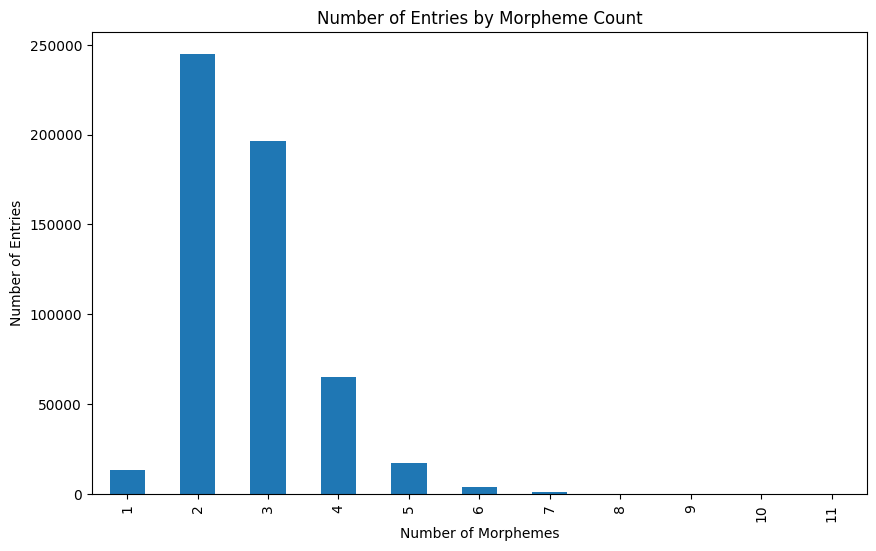

In [170]:
plot_entries_by_morpheme_count(state_complete)

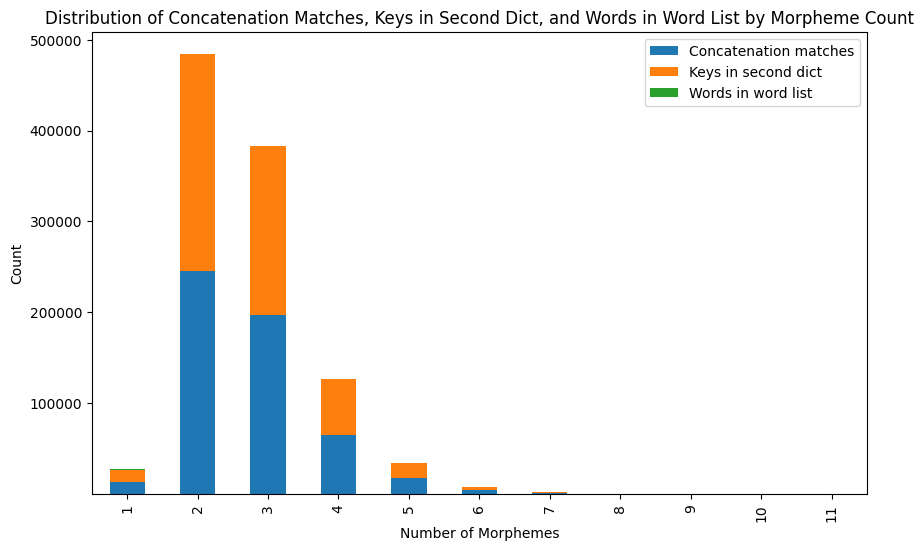

In [171]:
plot_stacked_bars(state_complete)

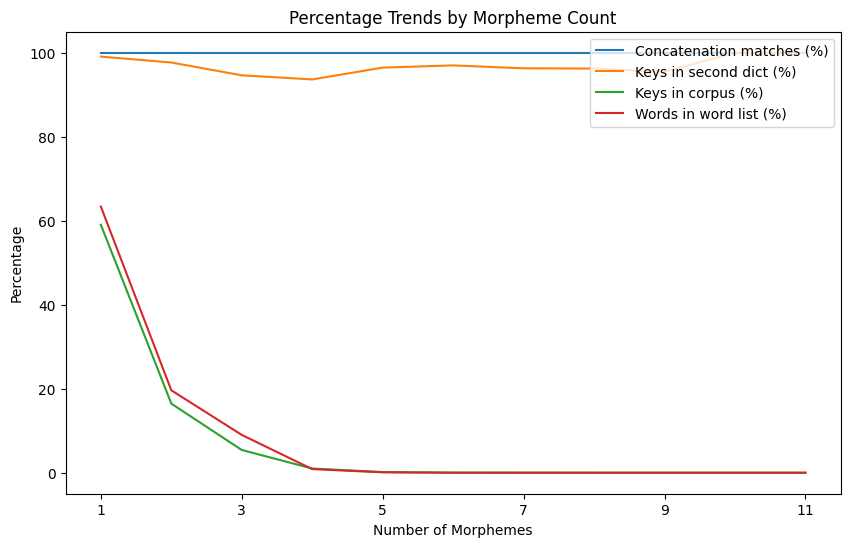

In [172]:
plot_percentage_lines(state_complete)

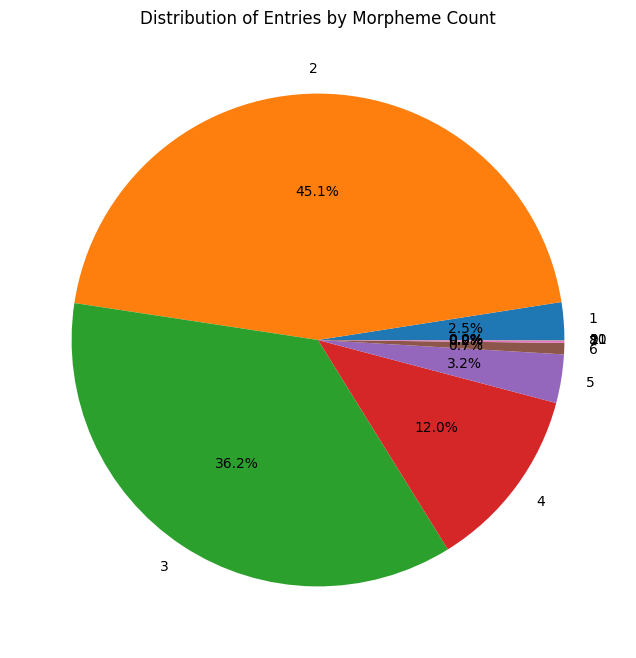

In [176]:
plot_pie_chart(state_complete)

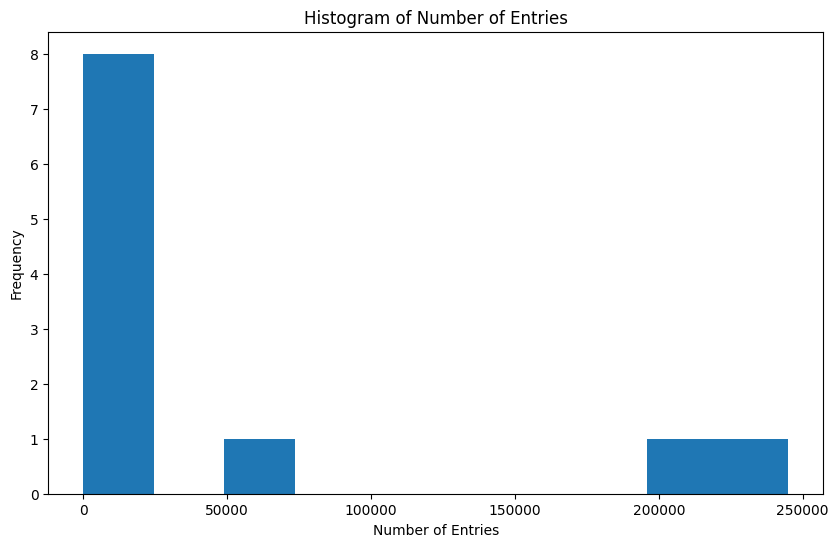

In [177]:
plot_histogram(state_complete)

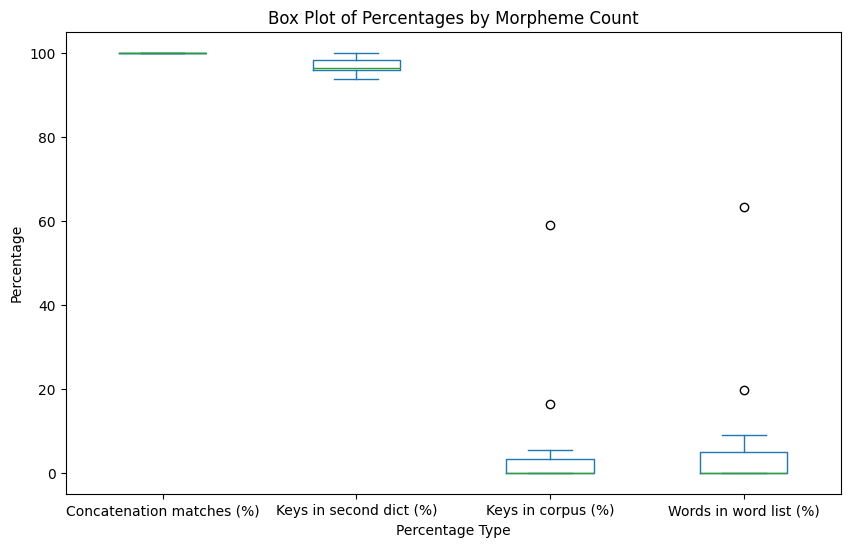

In [178]:
plot_box_plots(state_complete)

#### Multiple dictionaries

In [169]:
states = [state_0, state_1, state_2, state_3, state_4, state_5, state_6, state_7, state_8, state_9, state_10, state_11, state_complete]
labels = [f'Dict {i}' for i in range(13)]

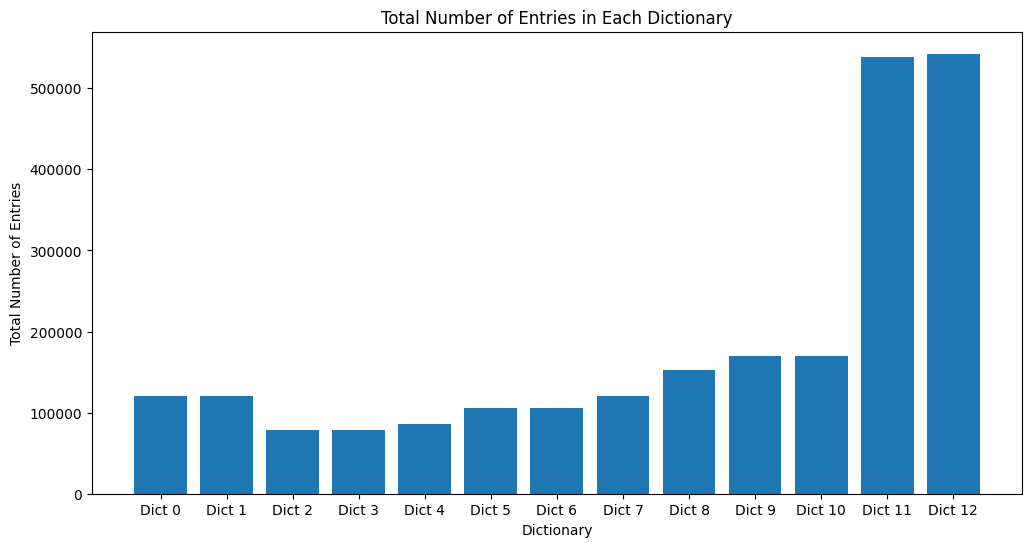

In [164]:
plot_total_entries_comparison(states, labels)

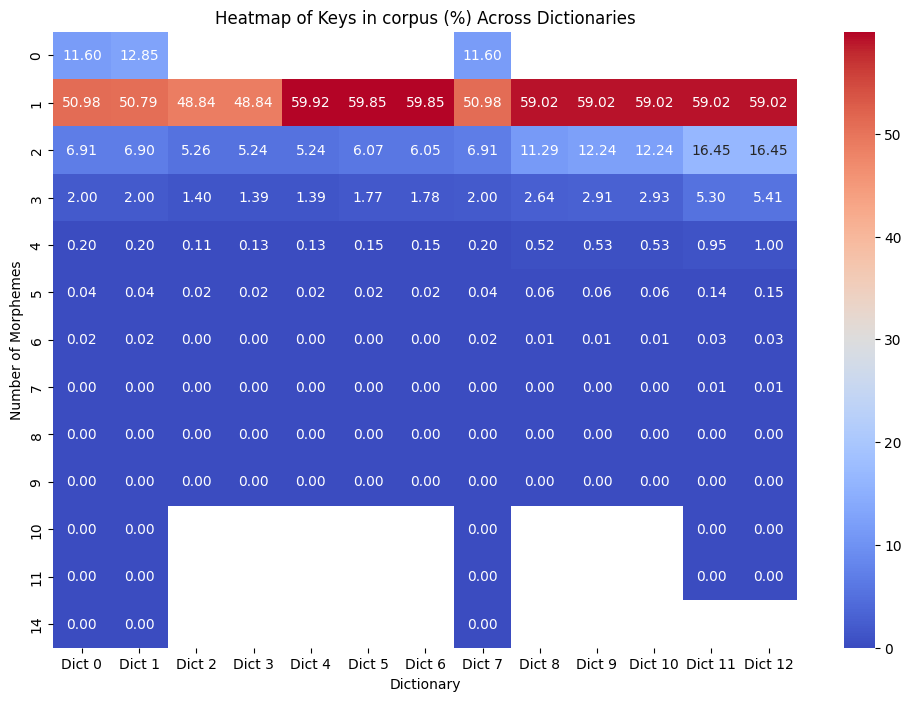

In [166]:
plot_percentage_heatmap(states, labels, 'Keys in corpus (%)')

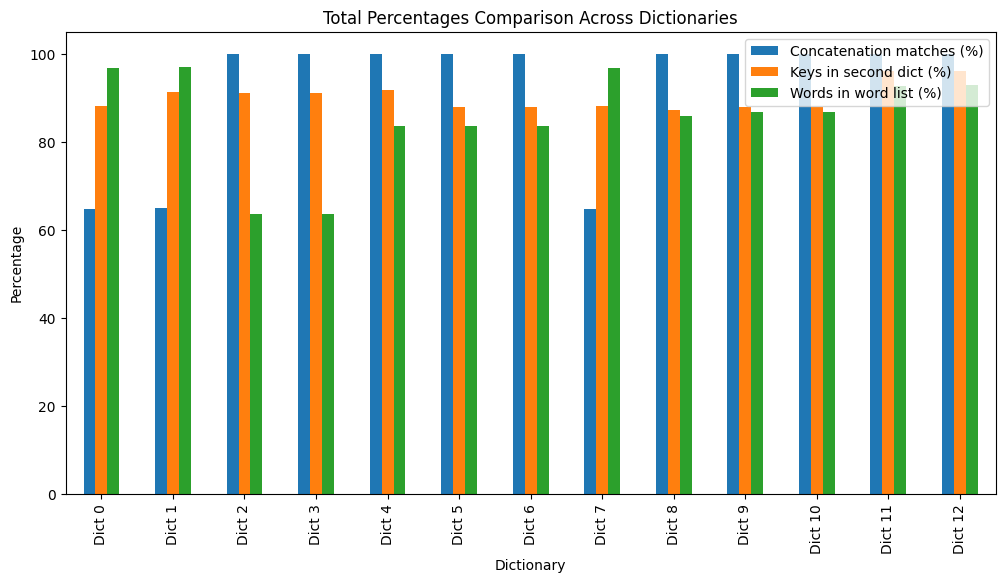

In [167]:
plot_total_percentages_comparison(states, labels)

## Evaluate Morfessor

Now that we have a ground truth dictionary with morphological segmentations, let's see the difference between how our Morfessor segmentation model divides the words and our own model

In [272]:
segmentation_dictionary = d13_lower

same = {}
different = {}

for word, seg in segmentation_dictionary.items():
    split = model_nl.viterbi_segment(word)[0]
    if split == seg:
        same[word] = split
    else:
        different[word] = {'celex': seg, 'morfessor': split}


In [273]:
diff_nonempty = {}

for word, segs in different.items():
    if len(segs['celex']) >= 1:
        diff_nonempty[word] = segs


In [275]:
print(len(same))
print(len(different))
print(len(diff_nonempty))

188249
153389
153389


## Tokenizer

In this section we will create a tokenizer with the segmentation dictionary we have just created. Because the tokenizer must also be able to handle words in that are not in the segmentation dictionary, we will train a help tokenizer. The tokenizer will work as a hybrid. If a word is in the dictionary, the segmentation from the dictionary will be used, if it is not the help tokenzer wil be used. 

In order to build dhit hybrig tokenizer we must perform the following steps:
- training a help tokenizer
- creating a tokenenizer class
- picking the best helpt tokenizer
- merging the vocabularies in this class
- writing a call function that decides whether the dictionary or help tokenizer will be used
- adding the methods that are necessary for the tokenizer to work in a standard huggingface pipeline (batch encode plus, etc.)

### Training a help tokenizer



It is done in the following way:
- remove the words that are in the dictionary from the corpus
- train the tokenizer with this file



In [ ]:
# from transformers import AutoTokenizer
# import datasets
# from datasets import load_dataset

# tokenizer_x = AutoTokenizer.from_pretrained("gpt2")
# segmentation_dictionary = segmentation_dictionary

# def lowercase_text(item):
#     return item.lower()

# def remove_words(item):
#     text = tokenizer_x._tokenizer.pre_tokenizer.pre_tokenize_str(item)
#     words_a = [word for word, offset in text]
#     words_b = [word.replace('Ġ', '') for word in words_a]
#     out = []
#     for i, word in enumerate(words_b):
#         if not word in segmentation_dictionary:
#             out.append(words_a[i])
#     return tokenizer_x.convert_tokens_to_string(out)

# def convert_text(input):
#     with open(input) as inp:
#         with open(input[:-4] + '_converted.txt', 'w') as outp:
#             for line in inp:
#                 line = lowercase_text(line)
#                 line = remove_words(line)
#                 outp.write(line)

We have done trained a few tokenizers in this way, of different sizes and with woth BPE and WordPiece. We will load them here:

In [216]:
from transformers import RobertaTokenizerFast

# WordPiece
help_tokenizer_20k = RobertaTokenizerFast.from_pretrained("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/HELP/MORF/help_20", max_len=512)
help_tokenizer_22k = RobertaTokenizerFast.from_pretrained("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/HELP/MORF/help_225", max_len=512)
help_tokenizer_25k = RobertaTokenizerFast.from_pretrained("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/HELP/MORF/help_25", max_len=512)
help_tokenizer_27k = RobertaTokenizerFast.from_pretrained("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/HELP/MORF/help_275", max_len=512)
help_tokenizer_28k = RobertaTokenizerFast.from_pretrained("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/HELP/MORF/help_2815", max_len=512)
help_tokenizer_30k = RobertaTokenizerFast.from_pretrained("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/HELP/MORF/help_30", max_len=512)

# BPE

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class

### Tokenizer class

#### For WordPiece help tokenizer

In [ ]:
import torch

class CustomTokenizerWP:

    def __init__(self, segmentation_dictionary, wp_tokenizer, max_length=512, pad_to_multiple_of=None):
        
        self.wp_tokenizer = wp_tokenizer
        self.wp_vocab = self.wp_tokenizer.get_vocab()

        self.segmentations = {word: seg for word, seg in segmentation_dictionary.items() if len(seg) > 0}
        self.seg_dict = {}
        for word, segs in self.segmentations.items():
            out = []
            for i, seg in enumerate(segs):
                if i == 0:
                    out.append(seg)
                else:
                    out.append('##' + seg)
            self.seg_dict[word] = out
        
        self.segments = {seg for segs in self.seg_dict.values() for seg in segs}
        

        self.vocab = self.wp_vocab.copy()
        
        for element in self.segments:
            if element not in self.vocab:
                self.vocab[element] = len(self.vocab) + 1
        

        self.l = len(self.vocab)



        special_tokens = ['<unk>', '<mask>', '<s>', '</s>', '<pad>', '<bos>', '<eos>']
        special_token_ids = {}
        
        for token in special_tokens:
            if token not in self.vocab:
                self.vocab[token] = len(self.vocab)
            special_token_ids[token] = self.vocab[token]
        
        self.unk_token = '<unk>'
        self.unk_token_id = special_token_ids['<unk>']
        
        self.mask_token = '<mask>'
        self.mask_token_id = special_token_ids['<mask>']
        
        self.cls_token = '<s>'
        self.cls_token_id = special_token_ids['<s>']
        
        self.sep_token = '</s>'
        self.sep_token_id = special_token_ids['</s>']
        
        self.pad_token = '<pad>'
        self.pad_token_id = special_token_ids['<pad>']
        
        self.bos_token = '<bos>'
        self.bos_token_id = special_token_ids['<bos>']
        
        self.eos_token = '<eos>'
        self.eos_token_id = special_token_ids['<eos>']
        

        self.special_tokens = [self.vocab['<mask>'], self.vocab['<s>'], self.vocab['</s>'], self.vocab['<pad>'], self.vocab['<unk>']]
        
        self.vocab_size = len(self.vocab)

        self.inverted_vocab = {value: key for key, value in self.vocab.items()}

        self.max_length = max_length
        self.pad_to_multiple_of = pad_to_multiple_of

        


    def get_vocab(self):
        return self.vocab


    def tokenize(self, seq):


        text = self.wp_tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(seq)
        words_a = [word for word in [word for word, offset in text]]
        
        words_b = [word.replace('##', '') for word in [word for word, offset in text]]
        tokens = []
        for i, word_b in enumerate(words_b):
            if word_b in self.seg_dict:
                tokens += self.seg_dict[word_b]
            else:
                if words_a[i][0] == '##':
                    tokens += self.wp_tokenizer.tokenize(word_b)
                else: 
                    tokens += self.wp_tokenizer.tokenize(' ' + word_b)    
        return tokens
        
        
    def encode(self, seq):


        return [self.bos_token_id] + self.convert_tokens_to_ids(self.tokenize(seq)) + [self.eos_token_id]

        


    def _convert_token_to_id(self, token):
        if token in self.vocab:
            return self.vocab[token]
        else:
            return self.unk_token_id

    
    def convert_tokens_to_ids(self, tokens):
        if isinstance(tokens, list):
            return [self._convert_token_to_id(token) for token in tokens]
        return self._convert_token_to_id(tokens)


    def _tokenize(self, seq):

        text = self.wp_tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(seq)
        words_a = [word for word in [word for word, offset in text]]
        
        words_b = [word.replace('##', '') for word in [word for word, offset in text]]
        tokens = []
        for i, word_b in enumerate(words_b):
            if word_b in self.seg_dict:
                tokens += self.seg_dict[word_b]
            else:
                if words_a[i][0] == '##':
                    tokens += self.wp_tokenizer.tokenize(word_b)
                else: 
                    tokens += self.wp_tokenizer.tokenize(' ' + word_b)    
        return tokens




    def _convert_id_to_token(self, id):
        return self.inverted_vocab[id]

    def convert_ids_to_tokens(self, ids):
        if isinstance(ids, list):
            return [self._convert_id_to_token(id) for id in ids]
        return self._convert_id_to_token(ids)
    
    def decode(self, ids):
        out = ''
        for id in ids:
            word = self._convert_id_to_token(id)
            if word[:2] == '##':
                out += word.replace('##', '')
            else:
                out += ' ' + word
        return out
        

    def get_special_tokens_mask(self, token_ids, already_has_special_tokens=False):
        return [1 if self._is_special_token(token_id) else 0 for token_id in token_ids]


    def _is_special_token(self, token_id):

        if token_id in self.special_tokens:
            return True
        else:
            return False

            

    def batch_encode_plus(self, texts, return_tensors=None, padding=False, truncation=False, max_length=None, add_special_tokens=False):
        batch_token_ids = [self.__call__(text, truncation=truncation, max_length=max_length, add_special_tokens=add_special_tokens)["input_ids"] for text in texts]
        
        if padding:
            if max_length is None:
                max_length = max(len(ids) for ids in batch_token_ids)
            batch_token_ids = [ids + [self.pad_token_id] * (max_length - len(ids)) for ids in batch_token_ids]
        
        if return_tensors == "pt":
            return {"input_ids": torch.tensor(batch_token_ids, dtype=torch.long)}
        return {"input_ids": batch_token_ids}



    def pad(self, batch, return_tensors="pt", pad_to_multiple_of=None):
        if pad_to_multiple_of is None:
            pad_to_multiple_of = self.pad_to_multiple_of

        input_ids_list = []
        for dictionary in batch:
            for key, value in dictionary.items():
                if key == "input_ids":
                    if isinstance(value, torch.Tensor):
                        input_ids_list.append(value.tolist())
                    else:
                        input_ids_list.append(value)


        max_length = max(len(x) for x in input_ids_list)
        
        if pad_to_multiple_of is not None:
            max_length = (max_length + pad_to_multiple_of - 1) // pad_to_multiple_of * pad_to_multiple_of
        
        padded_batch = []
        for seq in input_ids_list:
            if len(seq) < max_length:
                seq.extend([self.pad_token_id] * (max_length - len(seq)))
            padded_batch.append(seq)
        
        attention_list = []
        for inner_list in padded_batch:
            p_list = [1 if value != self.pad_token_id else 0 for value in inner_list]
            attention_list.append(p_list)
        
        if return_tensors == "pt":
            return {'input_ids': torch.tensor(padded_batch, dtype=torch.long), 'attention_mask': torch.tensor(attention_list, dtype=torch.long)}
        
        return {'input_ids': padded_batch, 'attention_mask': attention_list}


    def __call__(self, text, return_tensors=None, padding=False, truncation=False, max_length=None, add_special_tokens=False):
        if isinstance(text, list):
            self.batch_encode_plus(text, truncation=truncation, return_tensors=return_tensors, padding=padding, max_length=max_length, add_special_tokens=add_special_tokens)
        else:

            token_ids = self.encode(text) 

            if truncation and max_length:

                if len(token_ids) > max_length:
                    token_ids = token_ids[:max_length - 1] + [self.eos_token_id]


            if padding and max_length is not None:
                token_ids = token_ids + [self.pad_token_id] * (max_length - len(token_ids))

            if return_tensors == "pt":
                return {"input_ids": torch.tensor(token_ids, dtype=torch.long)}
            return {"input_ids": token_ids}

    
    def __len__(self):
        return self.vocab_size

#### For BPE help tokenizer

In [ ]:
class CustomTokenizerBPE:

    def __init__(self, segmentation_dictionary, bpe_tokenizer, max_length=512, pad_to_multiple_of=None):
        
        self.bpe_tokenizer = bpe_tokenizer
        self.bpe_vocab = self.bpe_tokenizer.get_vocab()

        self.segmentations = {word: seg for word, seg in segmentation_dictionary.items() if len(seg) > 0}
        self.seg_dict = {}
        for word, segs in self.segmentations.items():
            out = []
            for i, seg in enumerate(segs):
                if i == 0:
                    out.append('Ġ' + seg)
                else:
                    out.append(seg)
            self.seg_dict[word] = out
        
        self.segments = {seg for segs in self.seg_dict.values() for seg in segs}
        # self.seg_vocab = {seg: (i + len(self.bpe_vocab)) for i, seg in enumerate(self.segments) if not seg in self.bpe_vocab}
        
        # self.vocab = self.bpe_vocab | self.seg_vocab

        self.vocab = self.bpe_vocab.copy()
        
        for element in self.segments:
            if element not in self.vocab:
                self.vocab[element] = len(self.vocab) + 1

        self.mask_token = "<mask>"
        self.mask_token_id = self.vocab['<mask>']
        self.vocab[self.mask_token_id] = self.vocab['<mask>']
        
        self.cls_token = "<s>"
        self.cls_token_id = self.vocab['<s>']
        self.vocab[self.cls_token] = self.vocab['<s>']
        
        self.sep_token = "</s>"
        self.sep_token_id = self.vocab['</s>']
        self.vocab[self.sep_token] = self.vocab['</s>']
        
        self.pad_token = '<pad>'
        self.pad_token_id = self.vocab['<pad>']
        self.vocab[self.pad_token] = self.vocab['<pad>']
        


        # self.unk_token = '<|endoftext|>'
        # self.unk_token_id = self.vocab['<|endoftext|>']
        # self.vocab[self.unk_token] = self.vocab['<|endoftext|>']
        
        self.vocab['<unk>'] = len(self.vocab) + 1 
        self.unk_token = '<unk>'
        self.unk_token_id = self.vocab['<unk>']
        self.vocab[self.unk_token] = self.vocab['<unk>']
        
        # self.bos_token = '<|endoftext|>'
        # self.bos_token_id = self.vocab['<|endoftext|>']
        # self.vocab[self.bos_token] = self.vocab['<|endoftext|>']

        self.bos_token = '<s>'
        self.bos_token_id = self.vocab['<s>']
        self.vocab[self.bos_token] = self.vocab['<s>']
        
        self.eos_token = "</s>"
        self.eos_token_id = self.vocab["</s>"]
        self.vocab[self.eos_token] = self.vocab["</s>"]
        
        self.special_tokens = [self.vocab['<mask>'], self.vocab['<s>'], self.vocab['</s>'], self.vocab['<pad>'], self.vocab['<unk>']]
   
        
        self.vocab_size = len(self.vocab)

        self.inverted_vocab = {value: key for key, value in self.vocab.items()}

        self.max_length = max_length
        self.pad_to_multiple_of = pad_to_multiple_of

        


    def get_vocab(self):
        return self.vocab


    def tokenize(self, seq):


        text = self.bpe_tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(seq)
        words_a = [word for word in [word for word, offset in text]]
        
        words_b = [word.replace('Ġ', '') for word in [word for word, offset in text]]
        tokens = []
        for i, word_b in enumerate(words_b):
            if word_b in self.seg_dict:
                tokens += self.seg_dict[word_b]
            else:
                if words_a[i][0] == 'Ġ':
                    tokens += self.bpe_tokenizer.tokenize(' ' + word_b)
                else: 
                    tokens += self.bpe_tokenizer.tokenize(word_b)    
        return tokens
        
        
    def encode(self, seq):


        return [self.bos_token_id] + self.convert_tokens_to_ids(self.tokenize(seq)) + [self.eos_token_id]

        


    def _convert_token_to_id(self, token):
        if token in self.vocab:
            return self.vocab[token]
        else:
            return self.unk_token_id

    
    def convert_tokens_to_ids(self, tokens):
        if isinstance(tokens, list):
            return [self._convert_token_to_id(token) for token in tokens]
        return self._convert_token_to_id(tokens)


    def _tokenize(self, seq):
        text = self.bpe_tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(seq)
        words_a = [word for word in [word for word, offset in text]]
        
        words_b = [word.replace('Ġ', '') for word in [word for word, offset in text]]
        tokens = []
        for i, word_b in enumerate(words_b):
            if word_b in self.seg_dict:
                tokens += self.seg_dict[word_b]
            else:
                if words_a[i][0] == 'Ġ':
                    tokens += self.bpe_tokenizer.tokenize(' ' + word_b)
                else: 
                    tokens += self.bpe_tokenizer.tokenize(word_b)    
        return tokens




    def __call__(self, text, return_tensors=None, padding=False, truncation=False, max_length=None, add_special_tokens=False):
        if isinstance(text, list):
            self.batch_encode_plus(text, truncation=truncation, return_tensors=return_tensors, padding=padding, max_length=max_length, add_special_tokens=add_special_tokens)
        else:

            token_ids = self.encode(text) 


            if truncation and max_length:

                if len(token_ids) > max_length:
                    token_ids = token_ids[:max_length - 1] + [self.eos_token_id]

            # if truncation and max_length:
            #     # token_ids = [self.bos_token_id] + token_ids[:max_length - 2] + [self.eos_token_id]
            #     # token_ids = token_ids[:max_length]
            #     token_ids = [self.bos_token_id] + token_ids[:max_length - 2] + [self.eos_token_id]

            if return_tensors == "pt":
                return {"input_ids": torch.tensor(token_ids, dtype=torch.long)}
            return {"input_ids": token_ids}




    def _convert_id_to_token(self, id):
        return self.inverted_vocab[id]

    def convert_ids_to_tokens(self, ids):
        if isinstance(ids, list):
            return [self._convert_id_to_token(id) for id in ids]
        return self._convert_id_to_token(ids)
    
    def decode(self, ids):
        out = ''
        for id in ids:
            word = self._convert_id_to_token(id)
            if word[0] == 'Ġ':
                out += word.replace('Ġ', ' ')
            else:
                out += word
        return out
        

    def get_special_tokens_mask(self, token_ids, already_has_special_tokens=False):

        return [1 if self._is_special_token(token_id) else 0 for token_id in token_ids]


    def _is_special_token(self, token_id):

        if token_id in self.special_tokens:
            return True
        else:
            return False


    def batch_encode_plus(self, texts, return_tensors=None, padding=False, truncation=False, max_length=None, add_special_tokens=False):
        batch_token_ids = [self.__call__(text, truncation=truncation, max_length=max_length, add_special_tokens=add_special_tokens)["input_ids"] for text in texts]
        
        if padding:
            if max_length is None:
                max_length = max(len(ids) for ids in batch_token_ids)
            batch_token_ids = [ids + [self.pad_token_id] * (max_length - len(ids)) for ids in batch_token_ids]
        
        if return_tensors == "pt":
            return {"input_ids": torch.tensor(batch_token_ids, dtype=torch.long)}
        return {"input_ids": batch_token_ids}


    def pad(self, batch, return_tensors="pt", pad_to_multiple_of=None):
        if pad_to_multiple_of is None:
            pad_to_multiple_of = self.pad_to_multiple_of


        input_ids_list = []
        for dictionary in batch:
            for key, value in dictionary.items():
                if isinstance(value, torch.Tensor):
                    input_ids_list.append(value.tolist())


        max_length = max(len(x) for x in input_ids_list)
        
        if pad_to_multiple_of is not None:
            max_length = (max_length + pad_to_multiple_of - 1) // pad_to_multiple_of * pad_to_multiple_of
        
        padded_batch = []
        for seq in input_ids_list:
            if len(seq) < max_length:
                seq.extend([self.pad_token_id] * (max_length - len(seq)))
            padded_batch.append(seq)
        
        attention_list = []
        for inner_list in padded_batch:
            p_list = [1 if value < self.vocab_size else 0 for value in inner_list]
            attention_list.append(p_list)
        
        if return_tensors == "pt":
            return {'input_ids': torch.tensor(padded_batch, dtype=torch.long), 'attention_mask': torch.tensor(attention_list, dtype=torch.long)}
        
        return {'input_ids': padded_batch, 'attention_mask': attention_list}

    
    def __len__(self):
        return self.vocab_size

### Choosing the best help tokenizer

Create the tokenizers

In [217]:
segmentation_dictionary = d12

c_wp_20 = CustomTokenizerWP(segmentation_dictionary, help_tokenizer_20k)
c_wp_22 = CustomTokenizerWP(segmentation_dictionary, help_tokenizer_22k)
c_wp_25 = CustomTokenizerWP(segmentation_dictionary, help_tokenizer_25k)
c_wp_27 = CustomTokenizerWP(segmentation_dictionary, help_tokenizer_27k)
c_wp_28 = CustomTokenizerWP(segmentation_dictionary, help_tokenizer_28k)
c_wp_30 = CustomTokenizerWP(segmentation_dictionary, help_tokenizer_30k)

Comparing the resulting vocabulary size

In [220]:
print(len(c_wp_20))
print(len(c_wp_22))
print(len(c_wp_25))
print(len(c_wp_27))
print(len(c_wp_28))
print(len(c_wp_30))

43050
45158
47294
49457
50022
51653


Comparing how words are tokenized

The best help tokenizer:

In [ ]:
help_tokenizer = help_tokenizer_28k

## Comparison of different tokenizers

### Functions to evaluate the resulting tokenization

In [200]:



def tokenizer_segmentations(words, tokenizer, only_splits=False):
    # this function returns the tokenization of any tokenizer
    
    segs = {}

    for word in words:
        tokenization = tokenizer.tokenize(word)
        tokenization = [word.replace('Ġ', '') for word in tokenization]
        tokenization = [word.replace('##', '') for word in tokenization]
        segs[word] = tokenization
    
    if only_splits:
        return {word: seg for word, seg in segs.items() if len(seg) > 1}
    else:
        return segs




def simlex_celex(df, n, simlex_words, exclusive=False, with_segments=False):

    d = create_n_segmentations(df, 0)
    dic = {}

    for i in range(n + 2):
        data = create_n_segmentations(df, i)
        dic[i] = []
        for word in simlex_words:
            if word in data:
                dic[i].append(word)

    if exclusive:
        out = list(set(dic[n]) - set(dic[n + 1]))
    else:
        out = dic[n]
    
    if with_segments:
        out = {word: d[word] for word in out}
    
    print(f'There are {len(simlex_words)} unique words in the simlex dataset')
    
    if n != 1:
        if exclusive:
            print(f'There are {len(out)} words in simlex that have exactly {n} segments in CELEX')
        else:
            print(f'There are {len(out)} words in simlex that have at least {n} segments in CELEX')
    else:
        if exclusive:
            print(f'There are {len(out)} words in simlex that have exactly {n} segment in CELEX')
        else:
            print(f'There are {len(out)} words in simlex that have at least {n} segment in CELEX') 

    return out




def compare_tokenizer_segmentations_a(words, *tokenizers):

    results = {}

    for tokenizer in tokenizers:
        results[tokenizer] = tokenizer_segmentations(words, tokenizer)
    
    words_same = []
    words_diff = []

    for word in words:
        comp = {}
        for tokenizer in results:
            comp[tokenizer] = results[tokenizer][word]
        iterator = iter(comp.values())
        first_value = next(iterator)
        if all(value == first_value for value in iterator):
            words_same.append(word)
        else:
            words_diff.append(word)
    
    diff = {}
    for word in words_diff:
        c = {}
        for i, tokenizer in enumerate(tokenizers):
            c[i+1] = results[tokenizer][word]
        diff[word] = c

    
    if len(tokenizers) == 2:
        print(f'{len(words_same)} words out of the {len(words)} are tokenized in the same way by both tokenizers')
    else:
        print(f'{len(words_same)} words out of the {len(words)} are tokenized in the same way by all {len(tokenizers)} tokenizers')

    return words_same, words_diff, diff




def compare_tokenizer_with_celex(df, tokenizer):

    words = [word for word in df]
    segs = tokenizer_segmentations(words, tokenizer)

    words_same = []
    words_diff = []
    diff = {}

    for word in df:
        if df[word] == segs[word]:
            words_same.append(word)
        else:
            words_diff.append(word)
    
    diff = {}
    for word in words_diff:
        if len(segs[word]) >= 2:
            c = {}
            c['CELEX'] = df[word]
            c['tokenizer'] = segs[word]
            diff[word] = c
    
    return words_same, words_diff, diff

def return_words_not_in_dict(df, words):
    out = []
    for word in words:
        if word not in df:
            out.append(word)
    return out



def count_splits(words, tokenizer):

    toks = tokenizer_segmentations(words, tokenizer)

    split = {}
    no_split = []
    for word, segs in toks.items():
        if len(segs) > 1:
            split[word] = segs
        else:
            no_split.append(word)
    
    print(f'Number of words split up: {len(split)}')
    print(f'Number of words not split up: {len(no_split)}')

    return split, no_split

### Functions to evaluate speed

In [2143]:
import time

# function to create a dataset with text 
def create_test_set(dataset_generator, start, end):
    it = iter(dataset_generator)
    for _ in range(start):
        next(it)
    for _ in range(end - start + 1):
        yield next(it)


# function to measure time a function takes
def measure_execution_time(function, *args, **kwargs):

    start_time = time.time()
    function(*args, **kwargs)
    end_time = time.time()
    return end_time - start_time

# function to measure how much time it takes for a function to process data
# the function here should not take a generator as input
# the data is supplied by a generator
def measure_time_normal_function_x(data_generator, start, end, function, *args, **kwargs):

    gen = create_test_set(data_generator, start, end)
    t=0

    for i in gen:
        text = i['text']
        t += measure_execution_time(function, text, *args, **kwargs)
    
    return t

# this function takes a generator and function as input, and measures the time it takes to execute the function for every item in the generator
def measure_time_normal_function(data_generator, start, end, function, *args, **kwargs):

    gen = create_test_set(data_generator, start, end)
    t=0

    for i in gen:
        t += measure_execution_time(function, i, *args, **kwargs)
    
    return t


# function to measure how much time it takes a function to execute for every item in the generator
# same as the function above, but this one is for functions that take a generator as argument
def measure_time_generator_function(data_generator, start, end, function, *args, **kwargs):
    
    gen = create_test_set(data_generator, start, end)
    return measure_execution_time(function, gen, *args, **kwargs)



# function to use for the generators that yield dictionaries with 'text' as key
# this is for the iterable dictionary provided by hugging face
# (We now use a wrapper generator, so probably don't need this anymore)
def measure_time_iterable_text_dict(data_generator, start, end, function, *args, **kwargs):
    
    data_generator = create_text_generator(data_generator)
    gen = create_test_set(data_generator, start, end)
    return measure_execution_time(function, gen, *args, **kwargs)



# function to turn a generator that returns a dictionary with 'text' as key into a generator of the values
def create_text_generator(gen):
    for i in gen:
        yield i['text']




### Evaluation and comparisons

In order to evaluate the tokenizers, we need the following elements:
- the simlex words
- a corpus in the form of a generator
- a corpus in the form of a frequency dictionary

We will create various different versions of these three elements


Let's load the tokenizers we want to compare

In [222]:
from transformers import RobertaTokenizerFast

# tokenizers from Dutch large language models
tokenizer_bertje = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
tokenizer_robbert = AutoTokenizer.from_pretrained("DTAI-KULeuven/robbert-2023-dutch-large")

# WordPiece tokenizers
tokenizer_wp = RobertaTokenizerFast.from_pretrained("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/tokenizeWP/t50", max_len=512)

# BPE tokenizer
tokenizer_bpe = RobertaTokenizerFast.from_pretrained("/Users/jan/Documents/Master/Thesis/Code/Tokenizers/tokenizeBPE/t50", max_len=512)

# own tokenizer
tokenizer_own = c_wp_28


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [249]:
segs_own = tokenizer_segmentations(simlex_words, tokenizer_own)
segs_bertje = tokenizer_segmentations(simlex_words, tokenizer_bertje)

In [282]:
def dict_list_lengths_to_dataframe(dictionary):

    lengths = [len(v) for v in dictionary.values()]
    
    df = pd.DataFrame(lengths, columns=['Number of segments'])

    length_counts = df['Number of segments'].value_counts().reset_index()
    length_counts.columns = ['Number of segments', 'Count']

    length_counts = length_counts.sort_values(by='Number of segments').set_index('Number of segments')
    
    total_count = length_counts['Count'].sum()
    total_length_sum = sum(lengths)
    average_number_of_segments = round(total_length_sum / total_count, 2)
    
    total_count_row = pd.DataFrame({'Count': [total_count]}, index=['Number of words'])
    total_length_sum_row = pd.DataFrame({'Count': [total_length_sum]}, index=['Total number of segments'])
    average_number_of_segments_row = pd.DataFrame({'Count': [average_number_of_segments]}, index=['Average number of segments'])
    
    length_counts = pd.concat([length_counts, total_count_row, total_length_sum_row, average_number_of_segments_row])
    
    return length_counts


def compare_dictionaries(dicts, names=None):
    all_dataframes = []
    
    for i, dictionary in enumerate(dicts):
        df = dict_list_lengths_to_dataframe(dictionary)
        column_name = names[i] if names and i < len(names) else f'Tokenizer {i+1}'
        df.columns = [column_name]
        all_dataframes.append(df)
    
    combined_df = pd.concat(all_dataframes, axis=1)
    
    return combined_df


def compare_tokenizer_segmentations_b(*tokenizers, words, names=None):
    segs = []
    for tokenizer in tokenizers:
        segs.append(tokenizer_segmentations(words, tokenizer))
    
    if names is not None:
        out = compare_dictionaries(segs, names=names)
    else:
        out = compare_dictionaries(segs)
    
    return out

In [284]:
compare_tokenizer_segmentations_b(tokenizer_own, tokenizer_bpe, tokenizer_wp, tokenizer_bertje, tokenizer_robbert, words=simlex_words, names=['MORF', 'BPE', 'WordPiece', 'BERTje', 'RobBERT'])

,MORF,BPE,WordPiece,BERTje,RobBERT
1,691.00,604.00,884.00,906.00,906.00
2,224.00,341.00,138.00,102.00,119.00
3,113.00,93.00,22.00,27.00,18.00
4,16.00,7.00,1.00,9.00,2.00
5,1.00,NaN,NaN,1.00,NaN
Number of words,1045.00,1045.00,1045.00,1045.00,1045.00
Total number of segments,1547.00,1593.00,1230.00,1232.00,1206.00
Average number of segments,1.48,1.52,1.18,1.18,1.15


In [262]:
dict_list_lengths_to_dataframe(segs_own)

,Count
1,691.00
2,224.00
3,113.00
4,16.00
5,1.00
Number of words,1045.00
Total number of segments,1547.00
Average number of segments,1.48


In [268]:
tok_results = [segs_own, segs_bertje]
names = ['MORF', 'BERTje']
compare_dictionaries(tok_results)

,Tokenizer 1,Tokenizer 2
1,691.00,906.00
2,224.00,102.00
3,113.00,27.00
4,16.00,9.00
5,1.00,1.00
Number of words,1045.00,1045.00
Total number of segments,1547.00,1232.00
Average number of segments,1.48,1.18
